# ⚡🤖💻 Machine Learning Pipeline: IIoT Intrusion Detection 💻🤖⚡

###   Objective
This notebook implements a **binary and multiclass classification approach** to detect security anomalies in an Industrial Internet of Things (IIoT) network using **classical Machine Learning techniques** such as **XGBoost, LightGBM, and Random Forest**.

---

##   Network Traffic Data Analysis: Benign vs Attacks

### General Dataset Overview
This dataset, called *CICIOT 2025*, comes from a collection conducted on IoT devices connected to a local network.  
It contains both **benign records** (normal traffic) and **simulated network attacks**, including **DDoS (Distributed Denial of Service)** attacks, specifically **SYN Flood** attacks.

The main objective of this dataset is to support **network traffic analysis** and **automatic detection of abnormal behaviors**.  
It can be used to:
- **Train and evaluate** Machine Learning models for intrusion detection systems (IDS/IPS).
- **Analyze the differences** between normal and malicious traffic.
- **Build intelligent systems** capable of identifying attacks in real-time within IoT environments.

---

###  Dataset Structure
The dataset is organized into several categories of features:

####   Device Identification
- Device name and MAC address (e.g., router, IP camera, IoT gateway).

####  Labels
- Indicate whether a sample is benign or malicious, with different levels of granularity (`label_full`, `label1`, `label2`, etc.).

####   Temporal Information
- Start and end timestamps for each collected sample.

####  Log Features
- Information related to system or application logs generated during the sample.

####   Network Features
- Metrics describing network traffic, including:
  - Fragmentation
  - Packet size
  - Protocols used
  - Ports
  - TCP/IP flags
  - Time To Live (TTL), etc.

---

###   Key Differences Between Scenarios

####   Benign Traffic
- Non-null and consistent feature values.
- Presence of diverse IP/MAC addresses, ports, and protocols.
- Stable and regular network activity.

####   Attack Traffic (e.g., DDoS SYN Flood)
- Numerous null or zero values, reflecting saturated or abnormal traffic.
- Abnormally high TCP flags (`SYN`, `ACK`), typical of flooding attacks.
- Reduced diversity of IP addresses and ports used.

 

## Importing Libraries and Setting Up the Environment

This cell sets up the Python environment and imports all the necessary libraries for the **IIoT attack detection pipeline** using classical Machine Learning models.

### 1. Core Libraries
- `numpy`: for numerical operations and array manipulation.  
- `pandas`: for data loading, cleaning, and manipulation.  

### 2. Visualization
- `matplotlib.pyplot` and `seaborn`: for plotting graphs, heatmaps, and visualizing correlations or distributions of features.  

### 3. Statistics
- `scipy.stats`: for statistical analysis, such as normality tests or correlation analysis.  

### 4. Machine Learning Utilities
- `train_test_split`, `cross_val_score`, `StratifiedKFold`: for splitting data, cross-validation, and handling stratified folds.  
- `StandardScaler`, `LabelEncoder`: for feature scaling and encoding categorical labels.  
- `PCA`: for dimensionality reduction and feature extraction.  

### 5. Classical Machine Learning Models
- `RandomForestClassifier`: ensemble method for classification tasks.  
- `VotingClassifier`: combines multiple classifiers using majority voting.  
- `xgboost` (`xgb`): gradient boosting algorithm for high-performance classification.  
- `lightgbm` (`lgb`): gradient boosting algorithm optimized for speed and memory efficiency.  

### 6. Evaluation Metrics
- `accuracy_score`, `precision_score`, `recall_score`, `f1_score`: standard metrics for classification evaluation.  
- `classification_report`, `confusion_matrix`: detailed analysis of model performance.  
- `roc_auc_score`, `roc_curve`: metrics and curves for evaluating binary classification performance.  

 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_auc_score, roc_curve)
import xgboost as xgb
import lightgbm as lgb
from itertools import combinations
import warnings
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print("=" * 80)
print("PIPELINE ML UNIFIE POUR DETECTION D'ATTAQUES IIoT")
print("=" * 80)


PIPELINE ML UNIFIE POUR DETECTION D'ATTAQUES IIoT


## Global Configuration

This section defines the **general settings and hyperparameters** for the Machine Learning pipeline used for IIoT attack detection.

### Classification Types
- The pipeline supports both **binary classification** (benign vs attack) and **multiclass classification** (different types of attacks).

### Dataset Split Parameters
- **Test Size:** 15% of the dataset is reserved for testing.  
- **Validation Size:** 15% of the dataset is reserved for validation.  
- **Random State:** ensures reproducibility of splits and model results.  
- **N_JOBS:** uses all available CPU cores for parallel processing.

### Model Parameters
1. **Random Forest**
   - 300 trees, maximum depth 20.  
   - Minimum samples to split a node: 5; minimum samples per leaf: 2.  
   - `max_features='sqrt'` selects a subset of features at each split.  

2. **XGBoost**
   - 300 estimators, max depth 8, learning rate 0.1.  
   - Row (`subsample=0.8`) and feature (`colsample_bytree=0.8`) sampling for regularization.  
   - Evaluation metric: `logloss`.  

3. **LightGBM**
   - 300 estimators, max depth 8, learning rate 0.1.  
   - `num_leaves=31` and `min_child_samples=20` control tree complexity and prevent overfitting.  
   - Subsampling of rows and features similar to XGBoost.  
   - Silent mode (`verbose=-1`) for cleaner output.

### Summary
- These settings ensure that the **dataset splits, model hyperparameters, and computational settings** are standardized.  
- Printing the configuration helps verify the setup before running the pipeline.


In [12]:
# ============================================================================
# CONFIGURATION GLOBALE
# ============================================================================
CLASSIFICATION_TYPES = ['binary', 'multiclass']  # Les deux types
TEST_SIZE = 0.15
VAL_SIZE = 0.15
RANDOM_STATE = 42
N_JOBS = -1

# Parametres Random Forest
RF_PARAMS = {
    'n_estimators': 300,
    'max_depth': 20,
    'min_samples_split': 5,
    'min_samples_leaf': 2,
    'max_features': 'sqrt',
    'random_state': RANDOM_STATE,
    'n_jobs': N_JOBS
}

# Parametres XGBoost
XGB_PARAMS = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_weight': 3,
    'random_state': RANDOM_STATE,
    'n_jobs': N_JOBS,
    'eval_metric': 'logloss'
}

# Parametres LightGBM
LGB_PARAMS = {
    'n_estimators': 300,
    'max_depth': 8,
    'learning_rate': 0.1,
    'num_leaves': 31,
    'subsample': 0.8,
    'colsample_bytree': 0.8,
    'min_child_samples': 20,
    'random_state': RANDOM_STATE,
    'n_jobs': N_JOBS,
    'verbose': -1
}

print(f"\nConfiguration:")
print(f"   Types de classification: {CLASSIFICATION_TYPES}")
print(f"   Test size: {TEST_SIZE*100}%")
print(f"   Validation size: {VAL_SIZE*100}%")
print(f"   Random state: {RANDOM_STATE}")



Configuration:
   Types de classification: ['binary', 'multiclass']
   Test size: 15.0%
   Validation size: 15.0%
   Random state: 42


## Data Loading and Preparation

This section handles the **loading, merging, and labeling of the IIoT network traffic datasets** (benign and attack samples) from CSV files.

### 1. Dataset Directory
- `DATA_DIR` specifies the folder containing the CSV files for both benign and attack traffic.

### 2. Loading Benign Samples
- Loops through files named `benign_samples_1sec.csv` to `benign_samples_10sec.csv`.  
- Each file is loaded into a separate DataFrame and appended to a list.  
- After all files are loaded, they are concatenated into a single DataFrame `df_benign`.  
- Prints the number of rows and columns for each file and for the final dataset.

### 3. Loading Attack Samples
- Loops through files named `attack_samples_1sec.csv` to `attack_samples_10sec.csv`.  
- Each file is loaded and appended to a list, then concatenated into `df_attack`.  
- Prints information about each file and the final dataset.

### 4. Column Verification
- Ensures that **benign** and **attack** datasets have identical columns.  
- This is necessary before merging the datasets.

### 5. Adding Binary Labels
- Adds a new column `dataset_type` to distinguish between **benign** and **attack** samples.

### 6. Final Merge
- Combines `df_benign` and `df_attack` into a single dataset `df_all`.  
- Prints the shape of the combined dataset and displays the **distribution of classes** for both the original labels (`label2`) and the binary labels (`dataset_type`).

### Summary
- After this step, we have a **complete dataset** ready for analysis and modeling, containing both benign and attack samples with a **binary label** for classification tasks.


In [15]:
import os
import pandas as pd

# ===============================
# 0. CHEMIN DU DOSSIER CSV
# ===============================
DATA_DIR = "/kaggle/input/mydata"  # dossier contenant déjà les CSV

# ===============================
# 1. CHARGEMENT DES DONNEES
# ===============================
print("\n" + "=" * 80)
print("ETAPE 1 : CHARGEMENT DES DONNEES")
print("=" * 80)

seconds = list(range(1, 11))

# ===============================
# BENIGN CSV
# ===============================
df_benign_list = []

for sec in seconds:
    fichier = os.path.join(DATA_DIR, f"benign_samples_{sec}sec.csv")
    if os.path.exists(fichier):
        df = pd.read_csv(fichier)
        df_benign_list.append(df)
        print(f"{os.path.basename(fichier)} chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")
    else:
        print(f"{os.path.basename(fichier)} introuvable")

if df_benign_list:
    df_benign = pd.concat(df_benign_list, ignore_index=True)
else:
    raise FileNotFoundError("Aucun fichier BENIGN n'a été chargé")

print("\nDataset BENIGN")
print(f"Total : {df_benign.shape[0]} lignes, {df_benign.shape[1]} colonnes")

# ===============================
# ATTACK CSV
# ===============================
df_attack_list = []

for sec in seconds:
    fichier = os.path.join(DATA_DIR, f"attack_samples_{sec}sec.csv")
    if os.path.exists(fichier):
        df = pd.read_csv(fichier)
        df_attack_list.append(df)
        print(f"{os.path.basename(fichier)} chargé : {df.shape[0]} lignes, {df.shape[1]} colonnes")
    else:
        print(f"{os.path.basename(fichier)} introuvable")

if df_attack_list:
    df_attack = pd.concat(df_attack_list, ignore_index=True)
else:
    raise FileNotFoundError("Aucun fichier ATTACK n'a été chargé")

print("\nDataset ATTACK")
print(f"Total : {df_attack.shape[0]} lignes, {df_attack.shape[1]} colonnes")

# ===============================
# VERIFICATIONS
# ===============================
print("\nVérification des colonnes")
print("Colonnes identiques :", df_benign.columns.equals(df_attack.columns))

# ===============================
# AJOUT DU LABEL BINAIRE
# ===============================
df_benign["dataset_type"] = "benign"
df_attack["dataset_type"] = "attack"

# ===============================
# FUSION FINALE
# ===============================
df_all = pd.concat([df_benign, df_attack], ignore_index=True)

print("\nDataset combiné")
print("Shape :", df_all.shape)

print("\nDistribution des classes (label2)")
print(df_all["label2"].value_counts(dropna=False))

print("\nDistribution binaire (dataset_type)")
print(df_all["dataset_type"].value_counts())


ETAPE 1 : CHARGEMENT DES DONNEES
benign_samples_1sec.csv chargé : 136800 lignes, 94 colonnes
benign_samples_2sec.csv chargé : 68400 lignes, 94 colonnes
benign_samples_3sec.csv chargé : 45600 lignes, 94 colonnes
benign_samples_4sec.csv chargé : 34200 lignes, 94 colonnes
benign_samples_5sec.csv chargé : 27360 lignes, 94 colonnes
benign_samples_6sec.csv chargé : 22800 lignes, 94 colonnes
benign_samples_7sec.csv chargé : 19532 lignes, 94 colonnes
benign_samples_8sec.csv chargé : 17100 lignes, 94 colonnes
benign_samples_9sec.csv chargé : 15200 lignes, 94 colonnes
benign_samples_10sec.csv chargé : 13680 lignes, 94 colonnes

Dataset BENIGN
Total : 400672 lignes, 94 colonnes
attack_samples_1sec.csv chargé : 90391 lignes, 94 colonnes
attack_samples_2sec.csv chargé : 44744 lignes, 94 colonnes
attack_samples_3sec.csv chargé : 29627 lignes, 94 colonnes
attack_samples_4sec.csv chargé : 22165 lignes, 94 colonnes
attack_samples_5sec.csv chargé : 17695 lignes, 94 colonnes
attack_samples_6sec.csv char

## Exploratory Data Analysis (EDA)

This section performs a **preliminary exploration** of the combined IIoT dataset to understand its structure, distributions, and data quality before modeling.

### 1. General Information
- Number of rows and columns.  
- Memory usage of the dataset in megabytes.  
- This helps assess dataset size and resource requirements.

### 2. Label Distribution
- **Binary Classification (`dataset_type`)**: counts of `benign` vs `attack` samples.  
- **Multiclass Classification (`label2`)**: counts for each specific attack type.  
- Allows identifying **class imbalance** and planning preprocessing or balancing techniques.

### 3. Missing Values
- Computes the number and percentage of missing values per column.  
- Displays only columns with missing values in descending order.  
- Ensures data completeness or identifies features requiring imputation or removal.

### 4. Descriptive Statistics
- Shows descriptive statistics (mean, std, min, max, percentiles) for **numeric features**.  
- Only the **top 10 numeric features** are displayed for an overview.  
- Helps detect **outliers, feature ranges, and distributions**, useful for scaling and preprocessing.

### Summary
- EDA provides **insight into the dataset structure, class distributions, missing data, and numeric feature statistics**, which is critical before applying machine learning models.


In [16]:
# ============================================================================
# CELLULE 4: ANALYSE EXPLORATOIRE DES DONNEES (EDA)
# ============================================================================
print("\n" + "=" * 80)
print("ETAPE 2: ANALYSE EXPLORATOIRE DES DONNEES (EDA)")
print("=" * 80)

df = df_all.copy()

print(f"\nInformations generales:")
print(f"   Nombre de lignes: {df.shape[0]}")
print(f"   Nombre de colonnes: {df.shape[1]}")
print(f"   Memoire utilisee: {df.memory_usage(deep=True).sum() / 1024**2:.2f} MB")

# Distribution des labels
print(f"\nDistribution BINAIRE (dataset_type):")
print(df['dataset_type'].value_counts())
print(f"\nDistribution MULTICLASS (label2):")
print(df['label2'].value_counts())

# Valeurs manquantes
print(f"\nValeurs manquantes:")
missing = df.isnull().sum()
missing_pct = (missing / len(df)) * 100
missing_df = pd.DataFrame({
    'Colonnes': missing.index, 
    'Manquantes': missing.values, 
    'Pourcentage': missing_pct.values
})
missing_df = missing_df[missing_df['Manquantes'] > 0].sort_values('Manquantes', ascending=False)
if len(missing_df) > 0:
    print(missing_df.to_string(index=False))
else:
    print("   Aucune valeur manquante!")

# Statistiques descriptives
print(f"\nStatistiques descriptives des features numeriques (top 10):")
numeric_cols_eda = df.select_dtypes(include=[np.number]).columns
print(df[numeric_cols_eda].describe().T.head(10))



ETAPE 2: ANALYSE EXPLORATOIRE DES DONNEES (EDA)

Informations generales:
   Nombre de lignes: 685671
   Nombre de colonnes: 95
   Memoire utilisee: 4150.79 MB

Distribution BINAIRE (dataset_type):
dataset_type
benign    400672
attack    284999
Name: count, dtype: int64

Distribution MULTICLASS (label2):
label2
benign        400672
recon         105848
dos            57736
ddos           56692
mitm           25490
malware        24177
web             9040
bruteforce      6016
Name: count, dtype: int64

Valeurs manquantes:
   Aucune valeur manquante!

Statistiques descriptives des features numeriques (top 10):
                                    count      mean       std     min    25%  \
log_data-ranges_avg           685671.0000   59.8387  215.6094  0.0000 0.0000   
log_data-ranges_max           685671.0000   61.4138  218.0695  0.0000 0.0000   
log_data-ranges_min           685671.0000   57.3982  210.0544 -0.9400 0.0000   
log_data-ranges_std_deviation 685671.0000    1.2542   16.1928  

## EDA Visualizations

This section performs **visual exploration** of the IIoT dataset to understand distributions, feature importance, outliers, correlations, and attack type proportions.

### 1. Binary Class Distribution
- Bar chart showing the number of samples for **benign vs attack** (`dataset_type`).  
- Helps identify class imbalance and overall dataset composition.

### 2. Multiclass Distribution
- Bar chart showing the number of samples per **attack type** (`label2`).  
- Useful for spotting rare attack classes and planning balancing strategies.

### 3. Distribution of Key Features
- Histograms for important features such as:
  - `network_packets_all_count`  
  - `network_tcp-flags-syn_count`  
  - `network_payload-length_avg`  
  - `log_messages_count`  
- Log-scaled y-axis to visualize both frequent and rare values.  
- Helps understand feature ranges and detect anomalies.

### 4. Boxplots for Outlier Detection
- Boxplots of selected numeric features:
  - `network_packet-size_avg`, `network_ttl_avg`, `network_time-delta_avg`, `network_fragmentation-score`  
- Colored boxes for better readability.  
- Highlights **outliers** and extreme values that may affect model performance.

### 5. Attack Type Proportions
- Pie chart of different attack types within the attack subset.  
- Provides a quick overview of **relative frequencies of each attack**. 
### 6.  Correlation Heatmap
- **Lower triangular heatmap** showing correlations between the **top 20 features** by absolute correlation sum.  
- Masking the upper triangle avoids redundancy and improves clarity.  
- Helps detect highly correlated features that may need preprocessing (e.g., feature selection or dimensionality reduction).


### Summary
- These visualizations give a **comprehensive overview** of dataset distributions, feature behavior, correlations, and class imbalances.  
- They are essential for **feature engineering, preprocessing, and model selection** in the IIoT intrusion detection pipeline.


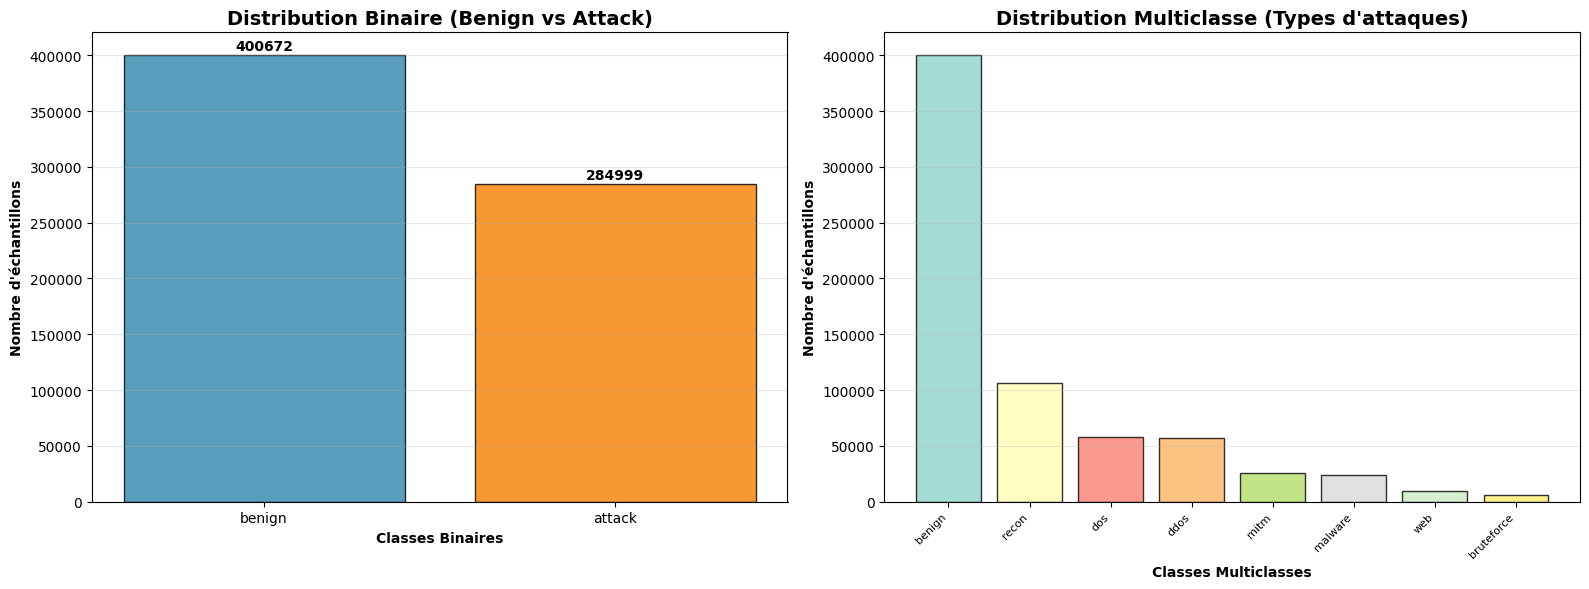

In [19]:
 # ============================================================================
# CELLULE 1: DISTRIBUTION BINAIRE ET MULTICLASSE
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# 1. Distribution binaire
ax1 = axes[0]
class_counts = df['dataset_type'].value_counts()
colors = ['#2E86AB', '#F77F00']
ax1.bar(range(len(class_counts)), class_counts.values, color=colors, alpha=0.8, edgecolor='black')
ax1.set_xticks(range(len(class_counts)))
ax1.set_xticklabels(class_counts.index, rotation=0)
ax1.set_xlabel('Classes Binaires', fontweight='bold')
ax1.set_ylabel('Nombre d\'échantillons', fontweight='bold')
ax1.set_title('Distribution Binaire (Benign vs Attack)', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(class_counts.values):
    ax1.text(i, v + max(class_counts.values)*0.01, str(v), ha='center', fontweight='bold')

# 2. Distribution multiclass
ax2 = axes[1]
class_counts_multi = df['label2'].value_counts()
colors_multi = plt.cm.Set3(np.linspace(0, 1, len(class_counts_multi)))
ax2.bar(range(len(class_counts_multi)), class_counts_multi.values, 
        color=colors_multi, alpha=0.8, edgecolor='black')
ax2.set_xticks(range(len(class_counts_multi)))
ax2.set_xticklabels(class_counts_multi.index, rotation=45, ha='right', fontsize=8)
ax2.set_xlabel('Classes Multiclasses', fontweight='bold')
ax2.set_ylabel('Nombre d\'échantillons', fontweight='bold')
ax2.set_title('Distribution Multiclasse (Types d\'attaques)', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


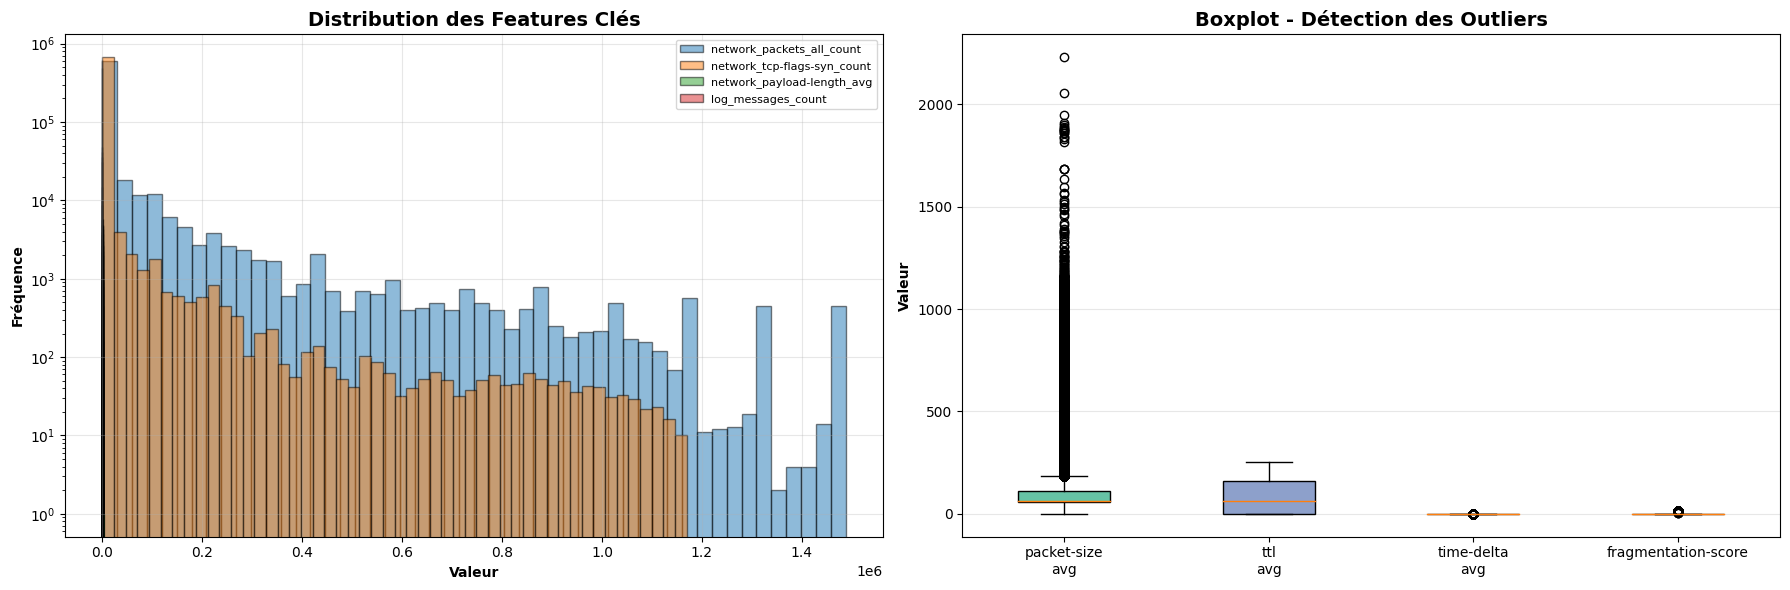

In [20]:
# ============================================================================
# CELLULE 2: DISTRIBUTION DES FEATURES CLES + DETECTION OUTLIERS
# ============================================================================
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Sélection des features clés (numériques uniquement)
key_features = ['network_packets_all_count', 'network_tcp-flags-syn_count', 
                'network_payload-length_avg', 'log_messages_count', 
                'network_packet-size_avg', 'network_ttl_avg', 
                'network_time-delta_avg', 'network_fragmentation-score']
key_features = [f for f in key_features if f in df.columns]

# 1. Histogrammes features clés
ax1 = axes[0]
for feat in key_features[:4]:  # les 4 premières pour histogrammes
    ax1.hist(df[feat].fillna(0), bins=50, alpha=0.5, label=feat, edgecolor='black')
ax1.set_xlabel('Valeur', fontweight='bold')
ax1.set_ylabel('Fréquence', fontweight='bold')
ax1.set_title('Distribution des Features Clés', fontsize=14, fontweight='bold')
ax1.legend(fontsize=8)
ax1.grid(True, alpha=0.3)
ax1.set_yscale('log')

# 2. Boxplots pour detection outliers
ax2 = axes[1]
data_to_plot = [df[f].fillna(0) for f in key_features[4:]]  # les autres features pour boxplot
labels_to_plot = [f.replace('network_', '').replace('_', '\n') for f in key_features[4:]]
if data_to_plot:
    bp = ax2.boxplot(data_to_plot, labels=labels_to_plot, patch_artist=True)
    for patch, color in zip(bp['boxes'], plt.cm.Set2(np.linspace(0, 1, len(data_to_plot)))):
        patch.set_facecolor(color)
ax2.set_ylabel('Valeur', fontweight='bold')
ax2.set_title('Boxplot - Détection des Outliers', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()


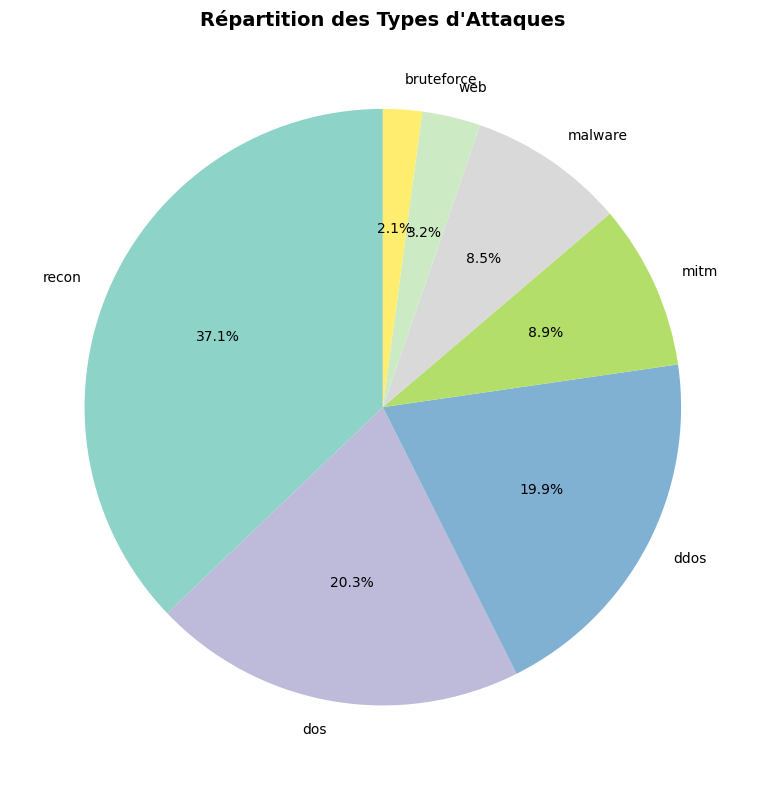

In [21]:
# ============================================================================
# CELLULE 3: REPARTITION DES TYPES D'ATTAQUES
# ============================================================================
attack_data = df[df['dataset_type'] == 'attack']
if len(attack_data) > 0:
    attack_dist = attack_data['label2'].value_counts()
    colors_pie = plt.cm.Set3(np.linspace(0, 1, len(attack_dist)))
    
    plt.figure(figsize=(8, 8))
    plt.pie(attack_dist.values, labels=attack_dist.index, autopct='%1.1f%%',
            colors=colors_pie, startangle=90)
    plt.title('Répartition des Types d\'Attaques', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.show()


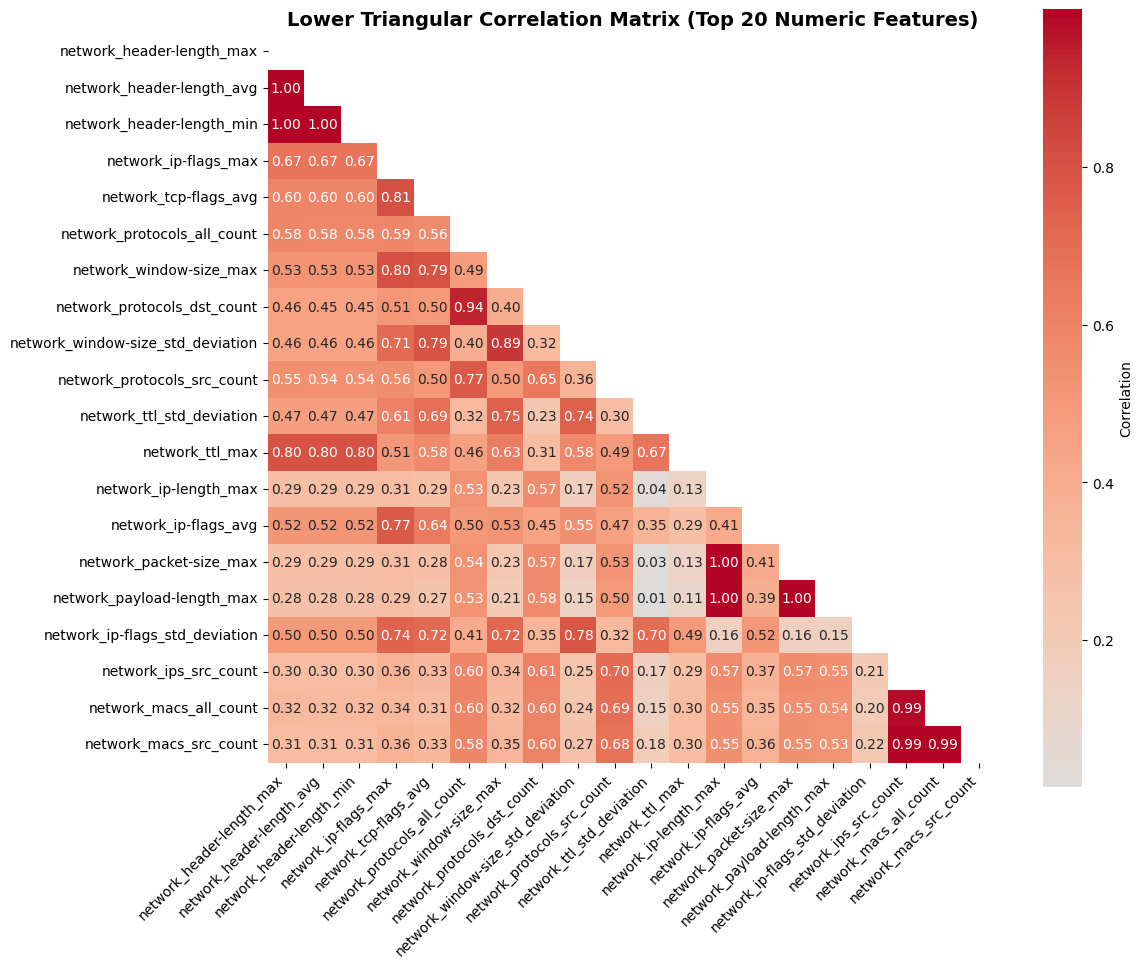

In [22]:
# ============================================================================
# CELLULE 4: LOWER TRIANGULAR CORRELATION MATRIX
# ============================================================================
# Sélection des colonnes numériques uniquement
numeric_cols = df.select_dtypes(include=[np.number]).columns

# Top 20 features numériques par somme de corrélation absolue
top_features = df[numeric_cols].corr().abs().sum().sort_values(ascending=False).head(20).index.tolist()

# Calcul de la corrélation
corr_top = df[top_features].corr()

# Masque pour ne garder que le triangle inférieur
mask = np.triu(np.ones_like(corr_top, dtype=bool))

# Création de la figure
plt.figure(figsize=(12,10))
sns.heatmap(corr_top, 
            mask=mask,
            annot=True,
            fmt='.2f',
            cmap='coolwarm',
            center=0,
            square=True,
            cbar_kws={'label': 'Correlation'})
plt.title('Lower Triangular Correlation Matrix (Top 20 Numeric Features)', fontsize=14, fontweight='bold')
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


# Cell 6: Feature Engineering

This cell prepares and enriches the data for the machine learning phase.

## 1. Removal of unnecessary columns
- Exclude textual columns, identifiers, or timestamps (`device_name`, `device_mac`, `label_full`, `timestamp`, etc.) that are not relevant for ML models.  
- Remove list-type columns (`network_ips_all`, `network_macs_dst`, `network_protocols_src`, etc.), which cannot be directly used numerically.

## 2. Creation of new features
To enrich the data and improve the models’ ability to detect anomalies, several derived features are computed:

1. **Packet ratios**  
   - `ratio_dst_packets` and `ratio_src_packets`: proportion of packets sent or received relative to the total.  

2. **TCP flags features**  
   - `tcp_flags_total`: sum of all TCP flags (ACK, SYN, FIN, RST, PSH, URG).  
   - `tcp_flags_diversity`: number of different TCP flags present (>0).  

3. **Payload/packet ratio**  
   - `ratio_payload_packet`: ratio of average payload size to average packet size.  

4. **IP diversity**  
   - `ip_diversity`: sum of distinct source and destination IPs.  
   - `ip_asymmetry`: absolute difference between source and destination IPs.  

5. **MAC diversity**  
   - `mac_diversity`: sum of distinct source and destination MACs.  

6. **Packet size variation**  
   - `packet_size_range`: difference between the maximum and minimum packet sizes.  
   - `packet_size_cv`: coefficient of variation of packet sizes (`std / mean`).  

7. **Fragmentation**  
   - `fragmentation_rate`: fragmentation score relative to the total number of packets.  

8. **Temporal density**  
   - `temporal_density`: number of packets per unit of time.  

9. **Port diversity**  
   - `port_diversity`: sum of distinct source and destination ports.  

10. **Protocol diversity**  
    - `protocol_diversity`: number of different protocols used.  

## 3. Selection of numerical features
- Only relevant numerical columns are kept for training (`numeric_cols`).  
- Textual columns or labels are excluded (`exclude_cols`).  

## 4. Final data preparation
- Missing (`NaN`) and infinite (`inf`, `-inf`) values are replaced with `0`.  
- `X` contains the final table of numerical features ready for machine learning.  
- `feature_names` contains the list of these feature names.  

> This feature engineering step is crucial to allow ML models (Random Forest, XGBoost, LightGBM) to better learn patterns between normal traffic and attacks.


In [24]:
# ============================================================================
# CELLULE 6: FEATURE ENGINEERING
# ============================================================================
print("\n" + "=" * 80)
print("ETAPE 3: FEATURE ENGINEERING")
print("=" * 80)

# Colonnes a exclure
exclude_cols = [
    'device_name', 'device_mac', 'label_full', 'label1', 'label2', 
    'label3', 'label4', 'timestamp', 'timestamp_start', 'timestamp_end',
    'dataset_type', 'timestamp_start_dt', 'hour'
]

# Colonnes de type liste
list_cols = [
    'log_data-types', 'network_ips_all', 'network_ips_dst', 'network_ips_src',
    'network_macs_all', 'network_macs_dst', 'network_macs_src',
    'network_ports_all', 'network_ports_dst', 'network_ports_src',
    'network_protocols_all', 'network_protocols_dst', 'network_protocols_src'
]

print("Suppression des colonnes de type liste...")
for col in list_cols:
    if col in df.columns:
        df = df.drop(columns=[col])

print("\nCreation de nouvelles features:")

# 1. Ratios de paquets
if 'network_packets_all_count' in df.columns:
    df['ratio_dst_packets'] = df['network_packets_dst_count'] / (df['network_packets_all_count'] + 1)
    df['ratio_src_packets'] = df['network_packets_src_count'] / (df['network_packets_all_count'] + 1)
    print("   Ratios de paquets crees")

# 2. Features TCP flags
tcp_flag_cols = ['network_tcp-flags-ack_count', 'network_tcp-flags-syn_count', 
                 'network_tcp-flags-fin_count', 'network_tcp-flags-rst_count',
                 'network_tcp-flags-psh_count', 'network_tcp-flags-urg_count']
if all(col in df.columns for col in tcp_flag_cols):
    df['tcp_flags_total'] = df[tcp_flag_cols].sum(axis=1)
    df['tcp_flags_diversity'] = (df[tcp_flag_cols] > 0).sum(axis=1)
    print("   Features TCP flags creees")

# 3. Ratio payload/packet
if 'network_payload-length_avg' in df.columns and 'network_packet-size_avg' in df.columns:
    df['ratio_payload_packet'] = df['network_payload-length_avg'] / (df['network_packet-size_avg'] + 1)
    print("   Ratio payload/packet cree")

# 4. Diversite IPs
if 'network_ips_all_count' in df.columns:
    df['ip_diversity'] = df['network_ips_src_count'] + df['network_ips_dst_count']
    df['ip_asymmetry'] = abs(df['network_ips_src_count'] - df['network_ips_dst_count'])
    print("   Features diversite IP creees")

# 5. Diversite MACs
if 'network_macs_all_count' in df.columns:
    df['mac_diversity'] = df['network_macs_src_count'] + df['network_macs_dst_count']
    print("   Diversite des MACs creee")

# 6. Variation packet size
if all(col in df.columns for col in ['network_packet-size_max', 'network_packet-size_min']):
    df['packet_size_range'] = df['network_packet-size_max'] - df['network_packet-size_min']
    df['packet_size_cv'] = df['network_packet-size_std_deviation'] / (df['network_packet-size_avg'] + 1)
    print("   Features variation packet size creees")

# 7. Fragmentation
if 'network_fragmentation-score' in df.columns and 'network_packets_all_count' in df.columns:
    df['fragmentation_rate'] = df['network_fragmentation-score'] / (df['network_packets_all_count'] + 1)
    print("   Taux de fragmentation cree")

# 8. Densite temporelle
if 'network_time-delta_avg' in df.columns and 'network_packets_all_count' in df.columns:
    df['temporal_density'] = df['network_packets_all_count'] / (df['network_time-delta_avg'] + 1e-6)
    print("   Densite temporelle creee")

# 9. Diversite ports
if 'network_ports_all_count' in df.columns:
    df['port_diversity'] = df['network_ports_src_count'] + df['network_ports_dst_count']
    print("   Diversite des ports creee")

# 10. Diversite protocoles
if 'network_protocols_all_count' in df.columns:
    df['protocol_diversity'] = df['network_protocols_all_count']
    print("   Diversite des protocoles creee")

print(f"\nNouvelles features creees: {df.shape[1] - df_all.shape[1] + len(list_cols)}")

# Selection des features numeriques
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in exclude_cols]

X = df[numeric_cols].values
feature_names = numeric_cols

# Gestion des valeurs manquantes et infinies
X = np.nan_to_num(X, nan=0.0, posinf=0.0, neginf=0.0)

print(f"\nDonnees finales:")
print(f"   Shape: {X.shape}")
print(f"   Nombre de features: {len(feature_names)}")



ETAPE 3: FEATURE ENGINEERING
Suppression des colonnes de type liste...

Creation de nouvelles features:
   Ratios de paquets crees
   Features TCP flags creees
   Ratio payload/packet cree
   Features diversite IP creees
   Diversite des MACs creee
   Features variation packet size creees
   Taux de fragmentation cree
   Densite temporelle creee
   Diversite des ports creee
   Diversite des protocoles creee

Nouvelles features creees: 14

Donnees finales:
   Shape: (685671, 85)
   Nombre de features: 85


# Cell 7: Correlation Analysis (Top 20 Features, Lower Triangular)

This cell focuses on studying the relationships between the **top 20 numerical features** and detecting redundancies.

## 1. Top 20 Features Selection
- The 20 features with the highest cumulative correlation strength are selected from the dataset.  
- This selection emphasizes the most informative features and simplifies the visualization.

## 2. Lower Triangular Correlation Matrix
- A **lower triangular heatmap** is displayed to avoid duplicate correlations.  
- Each cell shows the Pearson correlation coefficient between two features (range: -1 to 1).  
- Strong positive (close to +1) or negative correlations (close to -1) indicate redundancy between features.

## 3. Identifying Highly Correlated Features
- Pairs of features with absolute correlation > 0.9 are considered **highly correlated**.  
- These may introduce multicollinearity and reduce model performance if not addressed.

## 4. Removing Redundant Features
- For each highly correlated pair, the second feature is dropped to reduce redundancy.  
- Updated feature matrix (`X`) and feature names (`feature_names`) are refreshed.  
- This step improves robustness and generalization of ML models.

In [25]:
# ============================================================================
# CELLULE 7: ANALYSE DE CORRELATION
# ============================================================================
print("\n" + "=" * 80)
print("ETAPE 4: ANALYSE DE CORRELATION")
print("=" * 80)

df_corr = pd.DataFrame(X, columns=feature_names)

print("Calcul de la matrice de correlation...")
correlation_matrix = df_corr.corr()

# Features hautement correlees
print("\nFeatures hautement correlees (|corr| > 0.9):")
high_corr_pairs = []
for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        if abs(correlation_matrix.iloc[i, j]) > 0.9:
            high_corr_pairs.append({
                'Feature 1': correlation_matrix.columns[i],
                'Feature 2': correlation_matrix.columns[j],
                'Correlation': correlation_matrix.iloc[i, j]
            })

if high_corr_pairs:
    high_corr_df = pd.DataFrame(high_corr_pairs).sort_values('Correlation', ascending=False, key=abs)
    print(high_corr_df.head(20).to_string(index=False))
    print(f"\nTotal: {len(high_corr_pairs)} paires hautement correlees")
else:
    print("   Aucune paire hautement correlee trouvee")

# Suppression des features redondantes
print("\nTraitement des features redondantes...")
features_to_drop = set()
for pair in high_corr_pairs:
    features_to_drop.add(pair['Feature 2'])

if features_to_drop:
    print(f"   Suppression de {len(features_to_drop)} features redondantes")
    features_to_keep = [f for f in feature_names if f not in features_to_drop]
    X = df_corr[features_to_keep].values
    feature_names = features_to_keep
    correlation_matrix = df_corr[features_to_keep].corr()
    print(f"   Shape apres suppression: {X.shape}")
else:
    print("   Aucune feature a supprimer")



ETAPE 4: ANALYSE DE CORRELATION
Calcul de la matrice de correlation...

Features hautement correlees (|corr| > 0.9):
                  Feature 1                  Feature 2  Correlation
     network_macs_dst_count     network_macs_src_count       1.0000
     network_macs_src_count              mac_diversity       1.0000
     network_macs_dst_count              mac_diversity       1.0000
network_protocols_all_count         protocol_diversity       1.0000
  network_header-length_avg  network_header-length_min       1.0000
  network_header-length_avg  network_header-length_max       0.9999
  network_header-length_max  network_header-length_min       0.9998
            network_mss_avg            network_mss_max       0.9996
      network_ips_all_count      network_ips_dst_count       0.9994
      network_ip-length_max    network_packet-size_max       0.9993
      network_ip-length_max network_payload-length_max       0.9976
    network_packet-size_max network_payload-length_max       0.996

# Cell 8: Correlation Visualization (Top 20 Features, Lower Triangular)

This cell visualizes the correlations of the selected top 20 features.

## 1. Correlation Matrix Heatmap
- Shows the strength and direction of correlations between features using a **lower triangular matrix**.  
- Colors:
  - Red: strong positive correlation
  - Blue: strong negative correlation
  - White: weak correlation  
- Only the **top 20 features** are displayed for clarity.

## 2. Correlation Distribution
- Histogram showing the distribution of correlation coefficients among the top 20 features.  
- Red dashed lines at ±0.9 indicate high correlation thresholds.  
- Provides insight into whether features are mostly independent or redundant.

> **Purpose:**  
> - Detect and remove redundant features.  
> - Reduce multicollinearity in ML models.  
> - Improve feature selection and model interpretability.

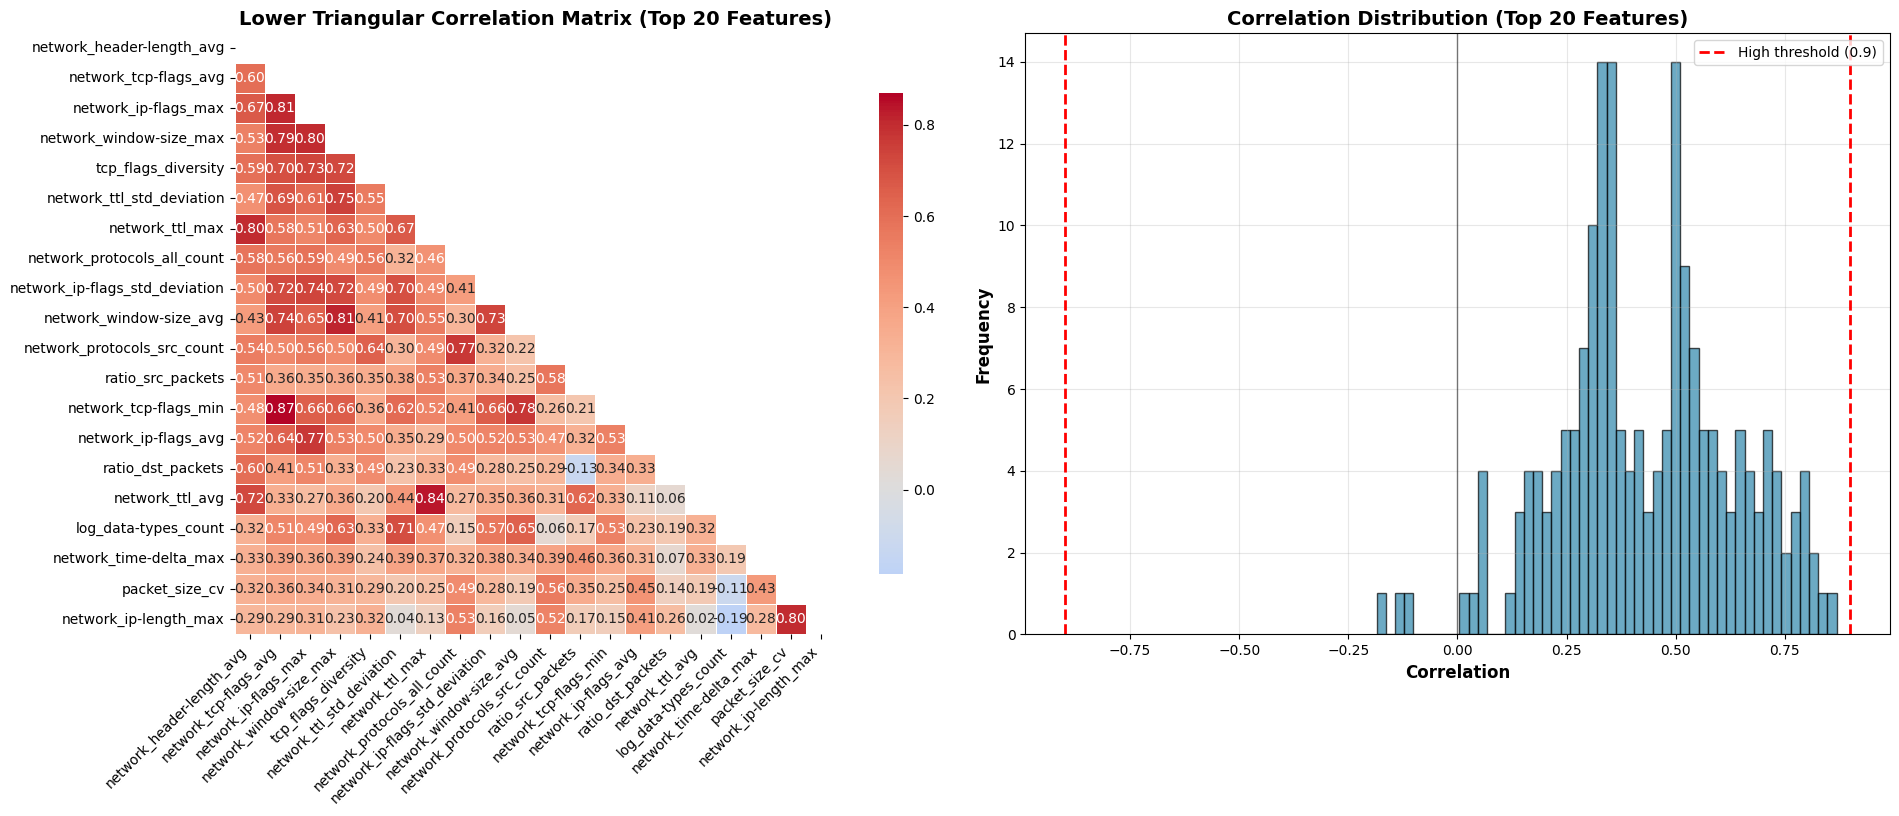


Correlation analysis completed!


In [26]:
# ============================================================================
# CELL 8: LOWER TRIANGULAR CORRELATION MATRIX (TOP 20 FEATURES)
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Select top 20 features based on correlation strength
top_features = correlation_matrix.abs().sum().sort_values(ascending=False).head(20).index.tolist()
corr_top = correlation_matrix.loc[top_features, top_features]

# Mask for lower triangular matrix
mask = np.triu(np.ones_like(corr_top, dtype=bool))

# Create figure
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# 1. Lower triangular heatmap
ax1 = axes[0]
sns.heatmap(corr_top, 
            mask=mask,        # Apply mask
            annot=True,       # Show values
            fmt='.2f',
            cmap='coolwarm', 
            center=0,
            square=True, 
            linewidths=0.5,
            cbar_kws={"shrink": 0.8},
            ax=ax1)
ax1.set_title('Lower Triangular Correlation Matrix (Top 20 Features)', fontsize=14, fontweight='bold')
plt.setp(ax1.get_xticklabels(), rotation=45, ha='right')
plt.setp(ax1.get_yticklabels(), rotation=0)

# 2. Correlation distribution
ax2 = axes[1]
corr_values = corr_top.values[np.triu_indices_from(corr_top.values, k=1)]
ax2.hist(corr_values, bins=50, color='#2E86AB', alpha=0.7, edgecolor='black')
ax2.axvline(x=0.9, color='red', linestyle='--', linewidth=2, label='High threshold (0.9)')
ax2.axvline(x=-0.9, color='red', linestyle='--', linewidth=2)
ax2.axvline(x=0, color='black', linestyle='-', linewidth=1, alpha=0.5)
ax2.set_xlabel('Correlation', fontweight='bold', fontsize=12)
ax2.set_ylabel('Frequency', fontweight='bold', fontsize=12)
ax2.set_title('Correlation Distribution (Top 20 Features)', fontsize=14, fontweight='bold')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nCorrelation analysis completed!")


# Cell 9: Standardization and PCA

This cell performs feature scaling and Principal Component Analysis (PCA) to prepare the data for visualization and dimensionality reduction.

## 1. Standardization
- Features in `X` are standardized using `StandardScaler`.  
- Standardization ensures that all features have **zero mean** and **unit variance**, which is essential for PCA and many ML algorithms.  
- Output: `X_scaled` — the standardized feature matrix.

## 2. PCA for Visualization
- **2D PCA:** Reduces the data to 2 principal components (`X_pca_2d`) for 2D visualization.  
- **3D PCA:** Reduces the data to 3 principal components (`X_pca_3d`) for 3D visualization.  
- PCA captures the directions of **maximum variance** in the data.



In [9]:
# ============================================================================
# CELLULE 9: STANDARDISATION ET PCA
# ============================================================================
print("\n" + "=" * 80)
print("ETAPE 5: STANDARDISATION ET PCA")
print("=" * 80)

# Standardisation
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
print("Donnees standardisees")

# PCA pour visualisation
print("\nCalcul du PCA...")
pca_2d = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca_2d = pca_2d.fit_transform(X_scaled)

pca_3d = PCA(n_components=3, random_state=RANDOM_STATE)
X_pca_3d = pca_3d.fit_transform(X_scaled)

# PCA complet pour variance
pca_full = PCA(random_state=RANDOM_STATE)
pca_full.fit(X_scaled)

print(f"\nVariance expliquee:")
print(f"   2 composantes: {sum(pca_2d.explained_variance_ratio_)*100:.2f}%")
print(f"   3 composantes: {sum(pca_3d.explained_variance_ratio_)*100:.2f}%")

cumsum_variance = np.cumsum(pca_full.explained_variance_ratio_)
n_components_95 = np.argmax(cumsum_variance >= 0.95) + 1
print(f"   {n_components_95} composantes pour 95% de variance")



ETAPE 5: STANDARDISATION ET PCA
Donnees standardisees

Calcul du PCA...

Variance expliquee:
   2 composantes: 30.42%
   3 composantes: 39.02%
   31 composantes pour 95% de variance


## 3. Explained Variance
- The proportion of total variance captured by the first few components is calculated:  
  - 2 components: ~30.42% of variance  
  - 3 components: ~39.02% of variance  
- Full PCA is computed to determine the number of components required to explain 95% of the variance:  
  - 31 components needed to reach 95% variance explained

> **Purpose:**  
> - Reduce dimensionality for visualization and downstream ML tasks.  
> - Identify the intrinsic dimensionality of the dataset.  
> - Ensure features contribute equally by standardization.


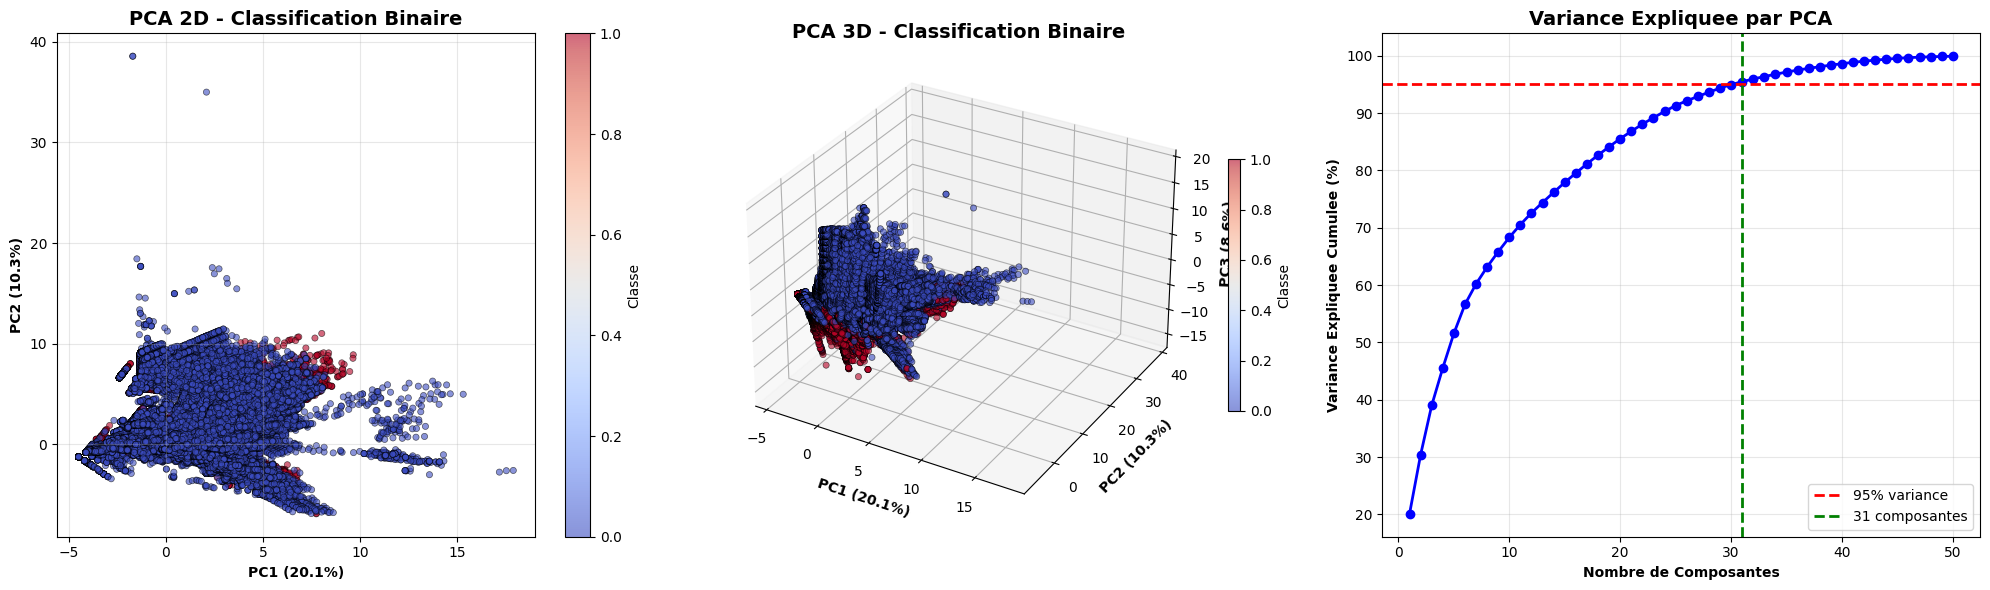


Recommandation: Garder 31 composantes pour 95% de variance
   Reduction: 55 -> 31 features

PCA terminee!


In [10]:
# ============================================================================
# CELLULE 10: VISUALISATIONS PCA
# ============================================================================
# Labels binaires pour visualisation
y_binary = LabelEncoder().fit_transform(df_all['dataset_type'])

fig = plt.figure(figsize=(20, 6))

# PCA 2D
ax1 = fig.add_subplot(1, 3, 1)
scatter = ax1.scatter(X_pca_2d[:, 0], X_pca_2d[:, 1], c=y_binary, 
                      cmap='coolwarm', alpha=0.6, s=20, edgecolors='k', linewidth=0.5)
ax1.set_xlabel(f'PC1 ({pca_2d.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca_2d.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
ax1.set_title('PCA 2D - Classification Binaire', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
plt.colorbar(scatter, ax=ax1, label='Classe')

# PCA 3D
ax2 = fig.add_subplot(1, 3, 2, projection='3d')
scatter_3d = ax2.scatter(X_pca_3d[:, 0], X_pca_3d[:, 1], X_pca_3d[:, 2], 
                         c=y_binary, cmap='coolwarm', alpha=0.6, s=20, 
                         edgecolors='k', linewidth=0.5)
ax2.set_xlabel(f'PC1 ({pca_3d.explained_variance_ratio_[0]*100:.1f}%)', fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca_3d.explained_variance_ratio_[1]*100:.1f}%)', fontweight='bold')
ax2.set_zlabel(f'PC3 ({pca_3d.explained_variance_ratio_[2]*100:.1f}%)', fontweight='bold')
ax2.set_title('PCA 3D - Classification Binaire', fontsize=14, fontweight='bold')
plt.colorbar(scatter_3d, ax=ax2, label='Classe', shrink=0.5)

# Variance expliquee cumulee
ax3 = fig.add_subplot(1, 3, 3)
n_components_plot = min(50, len(pca_full.explained_variance_ratio_))
ax3.plot(range(1, n_components_plot+1), 
         cumsum_variance[:n_components_plot]*100, 
         'bo-', linewidth=2, markersize=6)
ax3.axhline(y=95, color='r', linestyle='--', linewidth=2, label='95% variance')
ax3.axvline(x=n_components_95, color='g', linestyle='--', linewidth=2, 
            label=f'{n_components_95} composantes')
ax3.set_xlabel('Nombre de Composantes', fontweight='bold')
ax3.set_ylabel('Variance Expliquee Cumulee (%)', fontweight='bold')
ax3.set_title('Variance Expliquee par PCA', fontsize=14, fontweight='bold')
ax3.legend()
ax3.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nRecommandation: Garder {n_components_95} composantes pour 95% de variance")
print(f"   Reduction: {len(feature_names)} -> {n_components_95} features")

# Utiliser donnees standardisees pour les modeles
X_final = X_scaled

print("\nPCA terminee!")

### PCA 2D & 3D Analysis: Data Structure Visualization

#### 1. 2D & 3D PCA Plots
- These plots project your high-dimensional data (55 variables) into a reduced space to see if classes (red vs. blue) naturally separate.
- **Low linear separability:** Red and blue points are highly mixed, especially in the 2D plot. There is no clear boundary, suggesting that a simple linear model will struggle to classify these data perfectly using only the first two or three principal components.
- **Diluted information:**  
  - PC1 explains only 20.1% of the variance.  
  - PC2 explains only 10.3% of the variance.  
  - These relatively low scores indicate that the data structure is complex and cannot be summarized by only two “powerful” components.

#### 2. Explained Variance (Right-hand Plot)
- This plot shows the “information loss” as the number of components is reduced.
- **95% target:** The horizontal red line represents the threshold for retaining 95% of the original information.
- **Elbow point:** The vertical green line indicates that 31 components are needed to reach this threshold.
- **Interpretation:** Reducing from 55 to 31 variables removes “noise” (the remaining 5% of variance, often insignificant) while simplifying the model nearly by half.

#### Summary
- **Reduction:** 55 → 31 features.  
- **Benefit:** Reduces computational complexity and risk of overfitting, as the model focuses on the 31 directions containing most of the signal.
- **Important note:** Since the classes are highly mixed in 2D/3D, using these 31 components with a **non-linear algorithm** (e.g., Random Forest or XGBoost) is likely necessary to achieve good classification accuracy.


# Cell 11: `train_and_evaluate_models` Function

This function is designed to **train and evaluate multiple supervised classification models**, compare their performances, generate detailed reports, and visualize the results. It takes as input the dataset (`X`, `y`), a label encoder (`label_encoder`), and the classification type (`binary` or `multi-class`).

---

## 1. Data Preparation

1. **Train/Validation/Test Split**:
   - The dataset is first split into temporary training (`X_temp`, `y_temp`) and test sets (`X_test`, `y_test`) based on `TEST_SIZE`.
   - The temporary training set is then split into **train** and **validation** sets according to the adjusted `VAL_SIZE`.
   - Stratification is applied to preserve class distribution.

2. **Class Distribution Display**:
   - Shows the number of samples in each split.
   - Displays the distribution of classes across the dataset.

---

## 2. Individual Model Training

### a) Random Forest (RF)
- Trains a `RandomForestClassifier`.
- Evaluates:
  - Accuracy on train, validation, and test sets.
  - F1-score on test set.
  - 5-fold cross-validation.
  - ROC-AUC score for binary classification.
- Stores results and feature importances.

### b) XGBoost (XGB)
- Sets parameters dynamically based on classification type:
  - `binary:logistic` for binary.
  - `multi:softprob` for multi-class.
- Performs training and evaluation similar to RF.
- Converts labels to `int` for XGBoost compatibility.

### c) LightGBM (LGB)
- Parameters adjusted according to classification type.
- Trains with **early stopping** on the validation set.
- Evaluation metrics same as previous models.

---

## 3. Ensemble Models (Voting)

- Creates ensembles of **2 models** and a **full ensemble (RF+XGB+LGB)**.
- Uses **soft voting** (probability-based).
- Computes Test Accuracy and Test F1.
- Identifies the **best performing ensemble**.

---

## 4. Final Model Comparison

- Summary table including:
  - Train/Validation/Test Accuracy
  - Test F1-score
  - Mean and standard deviation of cross-validation
- Includes both individual models and ensembles.

---

## 5. Classification Reports

- Generates `classification_report` for each model and the best ensemble.
- Displays precision, recall, and F1-score for each class.

---

## 6. Feature Importance Analysis

- Builds a DataFrame containing feature importance for RF, XGB, and LGB.
- Normalizes and computes the average importance.
- Displays the **Top 20 most important features**.

---

## 7. Visualizations

1. Accuracy comparison (Train/Validation/Test) for each model.
2. Top 15 features for RF, XGB, and LGB (bar charts).
3. Confusion matrix for the best model/ensemble.
4. ROC curves (binary) or F1 scores (multi-class) for models.

---

## 8. Function Output

The function returns:
- `results`: dictionary with all trained models and their metrics.
- `comparison_final`: DataFrame with performance comparison.
- `feature_importance_df`: DataFrame of feature importances.
- `X_train, X_test, y_train, y_test`: final data splits for further use.
 

In [11]:
# ============================================================================
# CELLULE 11: FONCTION D'ENTRAINEMENT ET EVALUATION
# ============================================================================
def train_and_evaluate_models(X, y, label_encoder, classification_type):
    """
    Entraine et evalue les modeles RF, XGBoost, LightGBM et ensembles
    """
    print(f"\n{'='*80}")
    print(f"CLASSIFICATION {classification_type.upper()}")
    print(f"{'='*80}")
    
    # Split des donnees
    X_temp, X_test, y_temp, y_test = train_test_split(
        X, y, test_size=TEST_SIZE, stratify=y, random_state=RANDOM_STATE
    )
    
    val_size_adjusted = VAL_SIZE / (1 - TEST_SIZE)
    X_train, X_val, y_train, y_val = train_test_split(
        X_temp, y_temp, test_size=val_size_adjusted, stratify=y_temp, random_state=RANDOM_STATE
    )
    
    print(f"\nSplit effectue:")
    print(f"   Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(y)*100:.1f}%)")
    print(f"   Val:   {X_val.shape[0]} samples ({X_val.shape[0]/len(y)*100:.1f}%)")
    print(f"   Test:  {X_test.shape[0]} samples ({X_test.shape[0]/len(y)*100:.1f}%)")
    
    print(f"\nDistribution des classes:")
    unique, counts = np.unique(y, return_counts=True)
    for u, c in zip(unique, counts):
        class_name = label_encoder.classes_[u]
        print(f"   Classe {u} ({class_name}): {c} samples ({c/len(y)*100:.2f}%)")
    
    results = {}
    
    # ========== RANDOM FOREST ==========
    print(f"\n{'-'*80}")
    print("RANDOM FOREST")
    print(f"{'-'*80}")
    
    rf_model = RandomForestClassifier(**RF_PARAMS)
    rf_model.fit(X_train, y_train)
    
    cv_scores_rf = cross_val_score(rf_model, X_train, y_train, 
                                    cv=5, scoring='accuracy', n_jobs=N_JOBS)
    
    y_pred_rf = rf_model.predict(X_test)
    y_proba_rf = rf_model.predict_proba(X_test)
    
    rf_train_acc = accuracy_score(y_train, rf_model.predict(X_train))
    rf_val_acc = accuracy_score(y_val, rf_model.predict(X_val))
    rf_test_acc = accuracy_score(y_test, y_pred_rf)
    rf_test_f1 = f1_score(y_test, y_pred_rf, average='weighted')
    
    print(f"\nResultats Random Forest:")
    print(f"   Train Accuracy: {rf_train_acc:.4f}")
    print(f"   Val Accuracy:   {rf_val_acc:.4f}")
    print(f"   Test Accuracy:  {rf_test_acc:.4f}")
    print(f"   Test F1:        {rf_test_f1:.4f}")
    print(f"   CV Mean:        {cv_scores_rf.mean():.4f} (+/- {cv_scores_rf.std():.4f})")
    
    if classification_type == 'binary':
        rf_auc = roc_auc_score(y_test, y_proba_rf[:, 1])
        print(f"   Test ROC-AUC:   {rf_auc:.4f}")
    
    results['Random Forest'] = {
        'model': rf_model,
        'train_acc': rf_train_acc,
        'val_acc': rf_val_acc,
        'test_acc': rf_test_acc,
        'test_f1': rf_test_f1,
        'cv_scores': cv_scores_rf,
        'y_pred': y_pred_rf,
        'y_proba': y_proba_rf,
        'feature_importance': rf_model.feature_importances_
    }
    
     
       # ========== XGBOOST ==========
    print(f"\n{'-'*80}")
    print("XGBOOST")
    print(f"{'-'*80}")

    xgb_params = XGB_PARAMS.copy()
    
    if classification_type == 'binary':
        xgb_params['objective'] = 'binary:logistic'
    else:
        xgb_params['objective'] = 'multi:softprob'
        xgb_params['num_class'] = len(np.unique(y))
        xgb_params['eval_metric'] = 'mlogloss'  # <--- métrique compatible multi-class
    
    xgb_model = xgb.XGBClassifier(**xgb_params, use_label_encoder=False)
    
    # Vérification des types de labels
    y_train = y_train.astype(int)
    y_val = y_val.astype(int)
    y_test = y_test.astype(int)
    
    # Entraînement
    xgb_model.fit(
        X_train, y_train,
        eval_set=[(X_val, y_val)],
        verbose=False
    )
    
    # Cross-validation
    cv_scores_xgb = cross_val_score(
        xgb_model, X_train, y_train,
        cv=5, scoring='accuracy', n_jobs=N_JOBS
    )

    # Prédictions
    y_pred_xgb = xgb_model.predict(X_test)
    y_proba_xgb = xgb_model.predict_proba(X_test)
    
    # Accuracies et F1
    xgb_train_acc = accuracy_score(y_train, xgb_model.predict(X_train))
    xgb_val_acc = accuracy_score(y_val, xgb_model.predict(X_val))
    xgb_test_acc = accuracy_score(y_test, y_pred_xgb)
    xgb_test_f1 = f1_score(y_test, y_pred_xgb, average='weighted')
    
    print(f"\nResultats XGBoost:")
    print(f"   Train Accuracy: {xgb_train_acc:.4f}")
    print(f"   Val Accuracy:   {xgb_val_acc:.4f}")
    print(f"   Test Accuracy:  {xgb_test_acc:.4f}")
    print(f"   Test F1:        {xgb_test_f1:.4f}")
    print(f"   CV Mean:        {cv_scores_xgb.mean():.4f} (+/- {cv_scores_xgb.std():.4f})")
    
    if classification_type == 'binary':
        xgb_auc = roc_auc_score(y_test, y_proba_xgb[:, 1])
        print(f"   Test ROC-AUC:   {xgb_auc:.4f}")
    
    results['XGBoost'] = {
        'model': xgb_model,
        'train_acc': xgb_train_acc,
        'val_acc': xgb_val_acc,
        'test_acc': xgb_test_acc,
        'test_f1': xgb_test_f1,
        'cv_scores': cv_scores_xgb,
        'y_pred': y_pred_xgb,
        'y_proba': y_proba_xgb,
        'feature_importance': xgb_model.feature_importances_
    }

    
    # ========== LIGHTGBM ==========
    print(f"\n{'-'*80}")
    print("LIGHTGBM")
    print(f"{'-'*80}")
    
    lgb_params = LGB_PARAMS.copy()
    if classification_type == 'binary':
        lgb_params['objective'] = 'binary'
    else:
        lgb_params['objective'] = 'multiclass'
        lgb_params['num_class'] = len(np.unique(y))
    
    lgb_model = lgb.LGBMClassifier(**lgb_params)
    lgb_model.fit(X_train, y_train, eval_set=[(X_val, y_val)],
                  callbacks=[lgb.early_stopping(stopping_rounds=50, verbose=False)])
    
    cv_scores_lgb = cross_val_score(lgb_model, X_train, y_train,
                                     cv=5, scoring='accuracy', n_jobs=N_JOBS)
    
    y_pred_lgb = lgb_model.predict(X_test)
    y_proba_lgb = lgb_model.predict_proba(X_test)
    
    lgb_train_acc = accuracy_score(y_train, lgb_model.predict(X_train))
    lgb_val_acc = accuracy_score(y_val, lgb_model.predict(X_val))
    lgb_test_acc = accuracy_score(y_test, y_pred_lgb)
    lgb_test_f1 = f1_score(y_test, y_pred_lgb, average='weighted')
    
    print(f"\nResultats LightGBM:")
    print(f"   Train Accuracy: {lgb_train_acc:.4f}")
    print(f"   Val Accuracy:   {lgb_val_acc:.4f}")
    print(f"   Test Accuracy:  {lgb_test_acc:.4f}")
    print(f"   Test F1:        {lgb_test_f1:.4f}")
    print(f"   CV Mean:        {cv_scores_lgb.mean():.4f} (+/- {cv_scores_lgb.std():.4f})")
    
    if classification_type == 'binary':
        lgb_auc = roc_auc_score(y_test, y_proba_lgb[:, 1])
        print(f"   Test ROC-AUC:   {lgb_auc:.4f}")
    
    results['LightGBM'] = {
        'model': lgb_model,
        'train_acc': lgb_train_acc,
        'val_acc': lgb_val_acc,
        'test_acc': lgb_test_acc,
        'test_f1': lgb_test_f1,
        'cv_scores': cv_scores_lgb,
        'y_pred': y_pred_lgb,
        'y_proba': y_proba_lgb,
        'feature_importance': lgb_model.feature_importances_
    }
    
    # ========== VOTING ENSEMBLES ==========
    print(f"\n{'-'*80}")
    print("VOTING ENSEMBLES")
    print(f"{'-'*80}")
    
    models_dict = {
        'RF': rf_model,
        'XGB': xgb_model,
        'LGB': lgb_model
    }
    
    ensemble_results = []
    
    # Ensembles de 2 modeles
    for combo in combinations(models_dict.keys(), 2):
        voting = VotingClassifier(
            estimators=[(k, models_dict[k]) for k in combo],
            voting='soft',
            n_jobs=N_JOBS
        )
        voting.fit(X_train, y_train)
        y_pred = voting.predict(X_test)
        
        ensemble_results.append({
            'Combinaison': ' + '.join(combo),
            'Test Accuracy': accuracy_score(y_test, y_pred),
            'Test F1': f1_score(y_test, y_pred, average='weighted'),
            'Model': voting
        })
    
    # Ensemble complet
    voting_all = VotingClassifier(
        estimators=list(models_dict.items()),
        voting='soft',
        n_jobs=N_JOBS
    )
    voting_all.fit(X_train, y_train)
    y_pred_all = voting_all.predict(X_test)
    
    ensemble_results.append({
        'Combinaison': 'RF + XGB + LGB',
        'Test Accuracy': accuracy_score(y_test, y_pred_all),
        'Test F1': f1_score(y_test, y_pred_all, average='weighted'),
        'Model': voting_all
    })
    
    ensemble_df = pd.DataFrame(ensemble_results)
    print("\nResultats des ensembles:")
    print(ensemble_df[['Combinaison', 'Test Accuracy', 'Test F1']].to_string(index=False))
    
    best_ensemble = ensemble_df.loc[ensemble_df['Test Accuracy'].idxmax()]
    
    # ========== COMPARAISON FINALE ==========
    print(f"\n{'-'*80}")
    print("COMPARAISON DES MODELES")
    print(f"{'-'*80}")
    
    comparison_data = []
    for name in ['Random Forest', 'XGBoost', 'LightGBM']:
        comparison_data.append({
            'Modele': name,
            'Train Acc': results[name]['train_acc'],
            'Val Acc': results[name]['val_acc'],
            'Test Acc': results[name]['test_acc'],
            'Test F1': results[name]['test_f1'],
            'CV Mean': results[name]['cv_scores'].mean(),
            'CV Std': results[name]['cv_scores'].std()
        })
    
    for _, row in ensemble_df.iterrows():
        comparison_data.append({
            'Modele': f"Ensemble: {row['Combinaison']}",
            'Train Acc': np.nan,
            'Val Acc': np.nan,
            'Test Acc': row['Test Accuracy'],
            'Test F1': row['Test F1'],
            'CV Mean': np.nan,
            'CV Std': np.nan
        })
    
    comparison_final = pd.DataFrame(comparison_data)
    print("\n" + comparison_final.to_string(index=False))
    
    best_model_name = comparison_final.loc[comparison_final['Test Acc'].idxmax(), 'Modele']
    print(f"\nMeilleur modele: {best_model_name}")
    
    # ========== RAPPORTS DE CLASSIFICATION ==========
    print(f"\n{'-'*80}")
    print("RAPPORTS DE CLASSIFICATION")
    print(f"{'-'*80}")
    
    for model_name in ['Random Forest', 'XGBoost', 'LightGBM']:
        print(f"\n{model_name}:")
        print(classification_report(y_test, results[model_name]['y_pred'],
                                    target_names=label_encoder.classes_,
                                    zero_division=0))
    
    print(f"\nMeilleur Ensemble: {best_ensemble['Combinaison']}")
    y_pred_best = best_ensemble['Model'].predict(X_test)
    print(classification_report(y_test, y_pred_best,
                                target_names=label_encoder.classes_,
                                zero_division=0))
    
    # ========== FEATURE IMPORTANCE ==========
    print(f"\n{'-'*80}")
    print("FEATURE IMPORTANCE")
    print(f"{'-'*80}")
    
    feature_importance_df = pd.DataFrame({
        'Feature': feature_names,
        'RF': results['Random Forest']['feature_importance'],
        'XGB': results['XGBoost']['feature_importance'],
        'LGB': results['LightGBM']['feature_importance']
    })
    
    for col in ['RF', 'XGB', 'LGB']:
        feature_importance_df[col] /= feature_importance_df[col].sum()
    
    feature_importance_df['Mean'] = feature_importance_df[['RF','XGB','LGB']].mean(axis=1)
    feature_importance_df = feature_importance_df.sort_values('Mean', ascending=False)
    
    print("\nTop 20 features les plus importantes:")
    print(feature_importance_df[['Feature', 'Mean']].head(20).to_string(index=False))
    
    # ========== VISUALISATIONS ==========
    print(f"\n{'-'*80}")
    print("GENERATION DES VISUALISATIONS")
    print(f"{'-'*80}")
    
    fig = plt.figure(figsize=(20, 12))
    
    # 1. Comparaison des accuracies
    ax1 = plt.subplot(2, 3, 1)
    models = ['Random Forest', 'XGBoost', 'LightGBM']
    train_accs = [results[m]['train_acc'] for m in models]
    val_accs = [results[m]['val_acc'] for m in models]
    test_accs = [results[m]['test_acc'] for m in models]
    
    x = np.arange(len(models))
    width = 0.25
    
    ax1.bar(x - width, train_accs, width, label='Train', alpha=0.8, color='#2E86AB')
    ax1.bar(x, val_accs, width, label='Validation', alpha=0.8, color='#A23B72')
    ax1.bar(x + width, test_accs, width, label='Test', alpha=0.8, color='#F77F00')
    
    ax1.set_xlabel('Modeles', fontweight='bold')
    ax1.set_ylabel('Accuracy', fontweight='bold')
    ax1.set_title(f'Comparaison des Accuracies - {classification_type}', 
                  fontsize=14, fontweight='bold')
    ax1.set_xticks(x)
    ax1.set_xticklabels(models, rotation=15)
    ax1.legend()
    ax1.grid(True, alpha=0.3, axis='y')
    ax1.set_ylim([0, 1.1])
    
    # 2. Feature Importance - Random Forest
    ax2 = plt.subplot(2, 3, 2)
    top_features_rf = feature_importance_df.nlargest(15, 'RF')
    ax2.barh(range(len(top_features_rf)), top_features_rf['RF'], color='#06A77D')
    ax2.set_yticks(range(len(top_features_rf)))
    ax2.set_yticklabels(top_features_rf['Feature'], fontsize=8)
    ax2.set_xlabel('Importance', fontweight='bold')
    ax2.set_title('Top 15 Features - Random Forest', fontsize=12, fontweight='bold')
    ax2.invert_yaxis()
    ax2.grid(True, alpha=0.3, axis='x')
    
    # 3. Feature Importance - XGBoost
    ax3 = plt.subplot(2, 3, 3)
    top_features_xgb = feature_importance_df.nlargest(15, 'XGB')
    ax3.barh(range(len(top_features_xgb)), top_features_xgb['XGB'], color='#D62828')
    ax3.set_yticks(range(len(top_features_xgb)))
    ax3.set_yticklabels(top_features_xgb['Feature'], fontsize=8)
    ax3.set_xlabel('Importance', fontweight='bold')
    ax3.set_title('Top 15 Features - XGBoost', fontsize=12, fontweight='bold')
    ax3.invert_yaxis()
    ax3.grid(True, alpha=0.3, axis='x')
    
    # 4. Feature Importance - LightGBM
    ax4 = plt.subplot(2, 3, 4)
    top_features_lgb = feature_importance_df.nlargest(15, 'LGB')
    ax4.barh(range(len(top_features_lgb)), top_features_lgb['LGB'], color='#F77F00')
    ax4.set_yticks(range(len(top_features_lgb)))
    ax4.set_yticklabels(top_features_lgb['Feature'], fontsize=8)
    ax4.set_xlabel('Importance', fontweight='bold')
    ax4.set_title('Top 15 Features - LightGBM', fontsize=12, fontweight='bold')
    ax4.invert_yaxis()
    ax4.grid(True, alpha=0.3, axis='x')
    
    # 5. Matrice de confusion - Meilleur modele
    ax5 = plt.subplot(2, 3, 5)
    best_pred = y_pred_best if 'Ensemble' in best_model_name else results[best_model_name]['y_pred']
    cm = confusion_matrix(y_test, best_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=label_encoder.classes_,
                yticklabels=label_encoder.classes_,
                ax=ax5, cbar_kws={'label': 'Count'})
    ax5.set_title(f'Confusion Matrix - {best_model_name}', fontsize=12, fontweight='bold')
    ax5.set_ylabel('True Label')
    ax5.set_xlabel('Predicted Label')
    
    # 6. ROC Curve (si binaire) ou F1 scores
    ax6 = plt.subplot(2, 3, 6)
    if classification_type == 'binary':
        for model_name, color in zip(['Random Forest', 'XGBoost', 'LightGBM'], 
                                      ['#2E86AB', '#A23B72', '#F77F00']):
            fpr, tpr, _ = roc_curve(y_test, results[model_name]['y_proba'][:, 1])
            auc_score = roc_auc_score(y_test, results[model_name]['y_proba'][:, 1])
            ax6.plot(fpr, tpr, label=f'{model_name} (AUC={auc_score:.3f})', 
                    linewidth=2, color=color)
        
        ax6.plot([0, 1], [0, 1], 'k--', linewidth=1, label='Random')
        ax6.set_xlabel('False Positive Rate', fontweight='bold')
        ax6.set_ylabel('True Positive Rate', fontweight='bold')
        ax6.set_title('ROC Curves', fontsize=12, fontweight='bold')
        ax6.legend(loc='lower right')
        ax6.grid(True, alpha=0.3)
    else:
        # F1 scores par modele
        f1_scores = [results[m]['test_f1'] for m in ['Random Forest', 'XGBoost', 'LightGBM']]
        ax6.bar(models, f1_scores, color=['#2E86AB', '#A23B72', '#F77F00'], alpha=0.8)
        ax6.set_xlabel('Modeles', fontweight='bold')
        ax6.set_ylabel('F1 Score', fontweight='bold')
        ax6.set_title('F1 Scores - Test Set', fontsize=12, fontweight='bold')
        ax6.grid(True, alpha=0.3, axis='y')
        for i, v in enumerate(f1_scores):
            ax6.text(i, v + 0.01, f'{v:.3f}', ha='center', fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("\nVisualisations completees!")
    
    return results, comparison_final, feature_importance_df, X_train, X_test, y_train, y_test


# Cell 12: Binary Classification (Brief)

This cell performs **binary classification** to separate `Benign` vs `Attack` samples:

1. **Label Encoding**: Converts the `dataset_type` column into binary numeric labels (0/1) using `LabelEncoder`.
2. **Model Training & Evaluation**: Calls `train_and_evaluate_models` to train Random Forest, XGBoost, LightGBM, and their ensembles for binary classification.
3. **Outputs**: Returns model results, performance comparison, feature importance, and train/test splits for further analysis.



ETAPE 6: CLASSIFICATION BINAIRE (BENIGN VS ATTACK)

Classes binaires: ['attack' 'benign']

CLASSIFICATION BINARY

Split effectue:
   Train: 479969 samples (70.0%)
   Val:   102851 samples (15.0%)
   Test:  102851 samples (15.0%)

Distribution des classes:
   Classe 0 (attack): 284999 samples (41.56%)
   Classe 1 (benign): 400672 samples (58.44%)

--------------------------------------------------------------------------------
RANDOM FOREST
--------------------------------------------------------------------------------

Resultats Random Forest:
   Train Accuracy: 0.9642
   Val Accuracy:   0.9642
   Test Accuracy:  0.9623
   Test F1:        0.9620
   CV Mean:        0.9631 (+/- 0.0004)
   Test ROC-AUC:   0.9832

--------------------------------------------------------------------------------
XGBOOST
--------------------------------------------------------------------------------

Resultats XGBoost:
   Train Accuracy: 0.9656
   Val Accuracy:   0.9653
   Test Accuracy:  0.9633
   Test F1

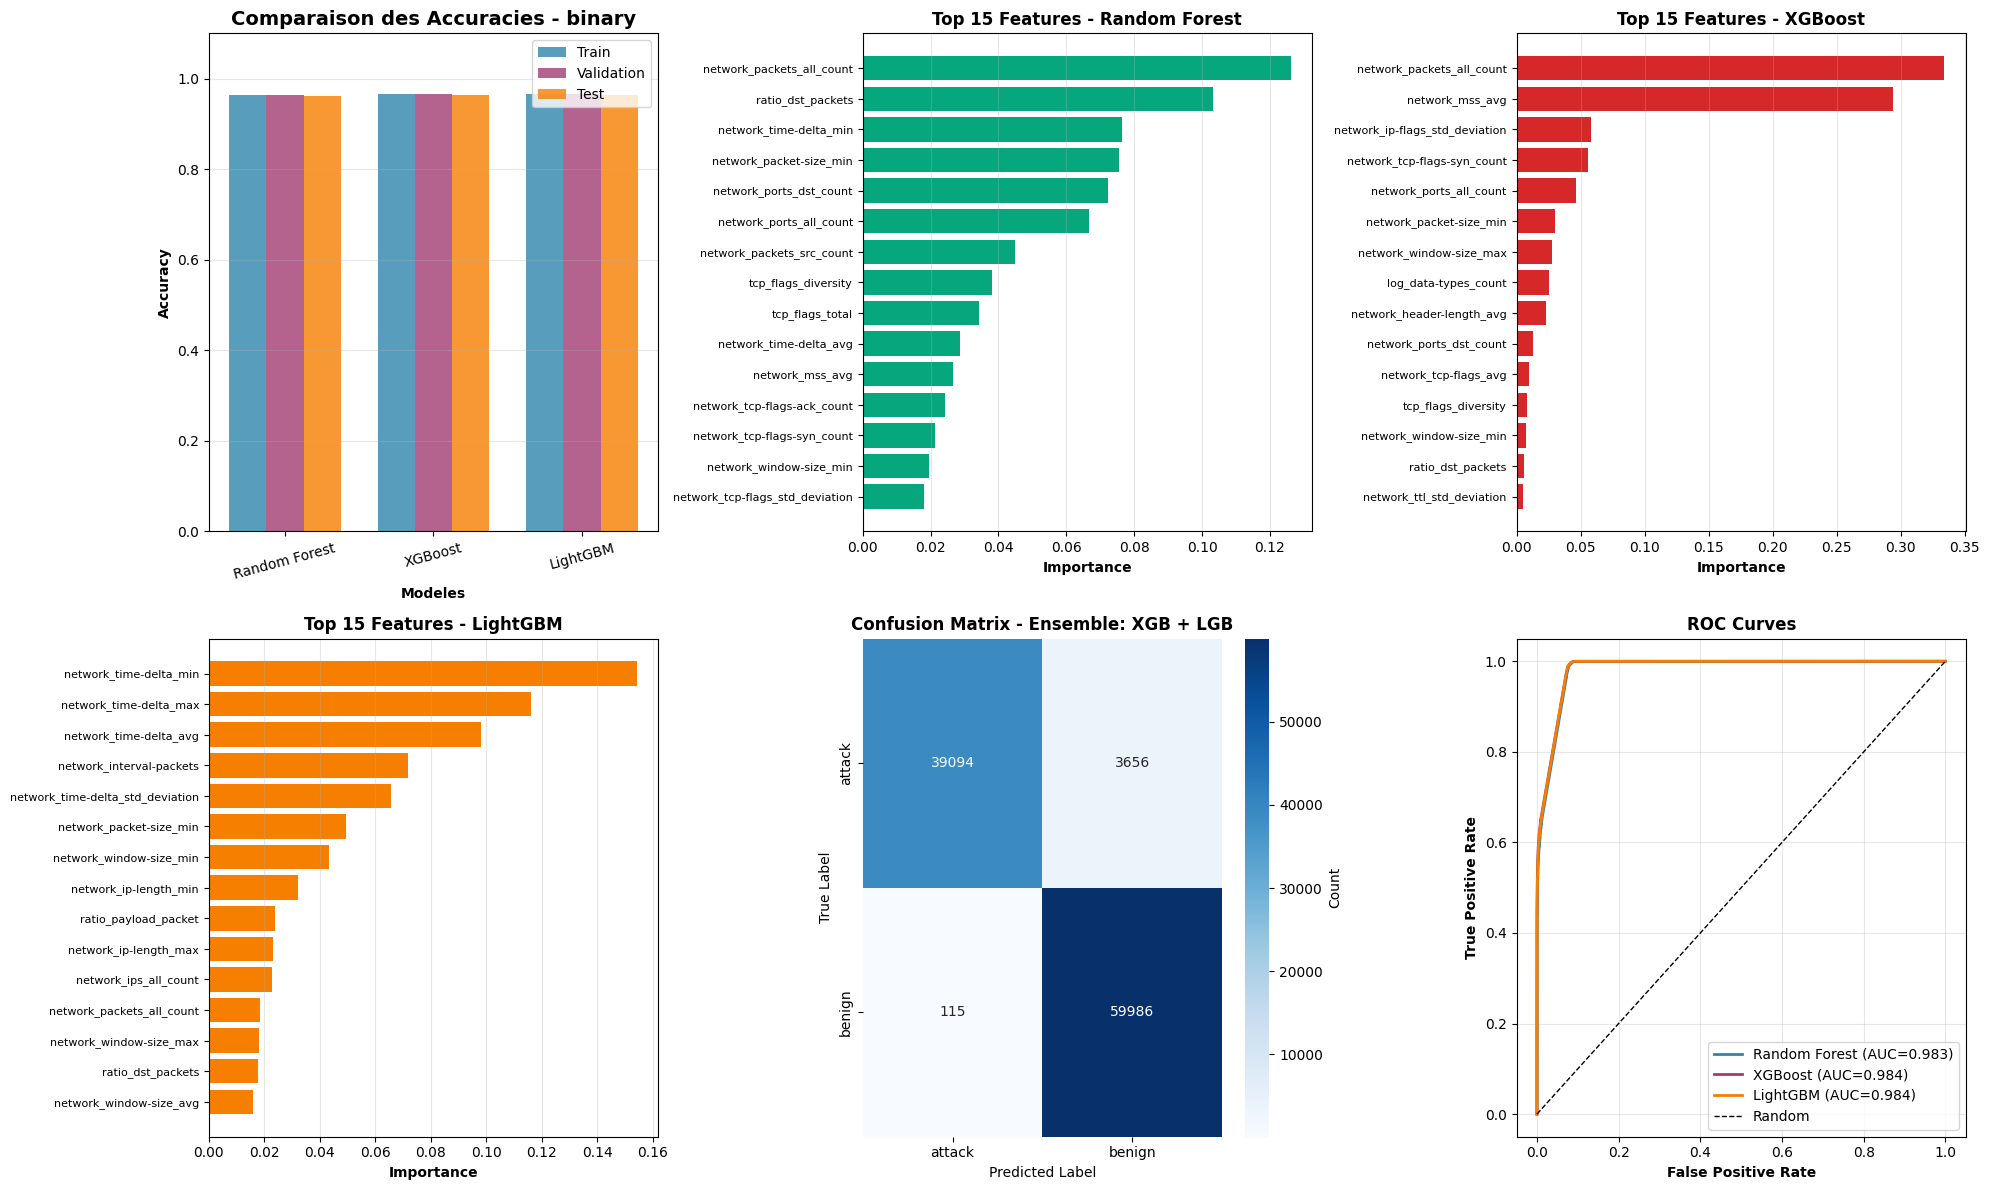


Visualisations completees!


In [12]:
# ============================================================================
# CELLULE 12: CLASSIFICATION BINAIRE
# ============================================================================
print("\n" + "=" * 80)
print("ETAPE 6: CLASSIFICATION BINAIRE (BENIGN VS ATTACK)")
print("=" * 80)

# Encodage binaire
label_encoder_binary = LabelEncoder()
y_binary = label_encoder_binary.fit_transform(df_all['dataset_type'])
print(f"\nClasses binaires: {label_encoder_binary.classes_}")

# Entrainement
results_binary, comparison_binary, importance_binary, X_train_bin, X_test_bin, y_train_bin, y_test_bin = \
    train_and_evaluate_models(X_final, y_binary, label_encoder_binary, 'binary')


## Interpretation of Results - Binary Classification (Benign vs Attack)

### 1. Dataset and Split
- **Binary classes**: `attack` vs `benign`.  
- **Data split**: 70% training, 15% validation, 15% test.  
- **Class distribution**: 41.6% attacks, 58.4% benign.  
- **Interpretation**: The dataset is slightly imbalanced but the stratified split preserves the class proportions in all subsets.

### 2. Model Performance Metrics
| Model         | Test Accuracy | Test F1  | ROC-AUC |
|---------------|---------------|----------|---------|
| Random Forest | 0.9623        | 0.9620   | 0.9832  |
| XGBoost       | 0.9633        | 0.9630   | 0.9844  |
| LightGBM      | 0.9631        | 0.9628   | 0.9841  |

**Interpretation**:  
- **Accuracy**: All models achieve very high accuracy (~96%), indicating strong overall predictive performance.  
- **F1-score**: Weighted F1-scores are high, balancing precision and recall, which is crucial for detecting both attacks and benign traffic.  
- **ROC-AUC**: Values above 0.98 suggest excellent discrimination between attack and benign classes.  
- **Conclusion**: XGBoost slightly outperforms the other individual models in test performance.

### 3. Ensemble Models
| Ensemble Combination | Test Accuracy | Test F1  |
|--------------------|---------------|----------|
| RF + XGB            | 0.9631        | 0.9628   |
| RF + LGB            | 0.9629        | 0.9627   |
| XGB + LGB           | 0.9633        | 0.9631   |
| RF + XGB + LGB      | 0.9631        | 0.9629   |

**Interpretation**:  
- The ensemble of **XGBoost + LightGBM** achieves the **highest accuracy and F1-score**, making it the best model for detecting attacks and benign activity.  
- Ensembles slightly improve robustness but only marginally increase performance over single models.

### 4. Classification Report Insights
- **Attack class**: Recall ~0.91 → ~9% of attacks may be missed.  
- **Benign class**: Recall ~1.00 → benign traffic is almost perfectly detected.  
- **Interpretation**: The model is slightly more conservative, prioritizing avoiding false positives on benign traffic while maintaining strong detection for attacks.

### 5. Feature Importance
- Top predictive features include:
  - **Network packet statistics**: `network_packets_all_count`, `network_packet-size_min`  
  - **Timing features**: `network_time-delta_min`, `network_time-delta_avg`  
  - **TCP flags & port usage**: `ratio_dst_packets`, `network_tcp-flags-syn_count`  
- **Interpretation**: Features related to packet counts, timing, and TCP flags are the most informative for distinguishing attack vs benign traffic, guiding future feature engineering and monitoring efforts.

### Conclusion
- **Best model**: Ensemble **XGBoost + LightGBM** based on highest Test Accuracy and F1-score.  
- **Performance**: High accuracy (~96%), robust F1 (~0.96), excellent discrimination (ROC-AUC ~0.98).  
- **Key insight**: Network-related features are critical for attack detection, which can guide both feature selection and network monitoring strategies.


## Cell 13: Multiclass Classification (Attack Types) - Brief

- **Objective**: Classify network traffic into multiple attack types instead of just binary attack vs benign.  
- **Label Encoding**: Converts textual attack labels (`label2`) into numeric form using `LabelEncoder`.  
- **Model Training**: Trains and evaluates **Random Forest, XGBoost, LightGBM, and ensemble models** using `train_and_evaluate_models`.  
- **Data Split**: Stratified split into training, validation, and test sets.  
- **Outputs**:  
  - `results_multi`: model predictions, probabilities, and feature importance  
  - `comparison_multi`: performance comparison across models  
  - `importance_multi`: feature importance  
  - `X_train_multi, X_test_multi, y_train_multi, y_test_multi`: dataset splits for further use  
- **Summary**: Extends binary classification to multiple attack categories, enabling performance evaluation for each attack type and identification of important predictive features.



ETAPE 7: CLASSIFICATION MULTICLASSE (TYPES D'ATTAQUES)

Classes multiclasses (8): ['benign' 'bruteforce' 'ddos' 'dos' 'malware' 'mitm' 'recon' 'web']

CLASSIFICATION MULTICLASS

Split effectue:
   Train: 479969 samples (70.0%)
   Val:   102851 samples (15.0%)
   Test:  102851 samples (15.0%)

Distribution des classes:
   Classe 0 (benign): 400672 samples (58.44%)
   Classe 1 (bruteforce): 6016 samples (0.88%)
   Classe 2 (ddos): 56692 samples (8.27%)
   Classe 3 (dos): 57736 samples (8.42%)
   Classe 4 (malware): 24177 samples (3.53%)
   Classe 5 (mitm): 25490 samples (3.72%)
   Classe 6 (recon): 105848 samples (15.44%)
   Classe 7 (web): 9040 samples (1.32%)

--------------------------------------------------------------------------------
RANDOM FOREST
--------------------------------------------------------------------------------

Resultats Random Forest:
   Train Accuracy: 0.9618
   Val Accuracy:   0.9580
   Test Accuracy:  0.9586
   Test F1:        0.9579
   CV Mean:        0.958

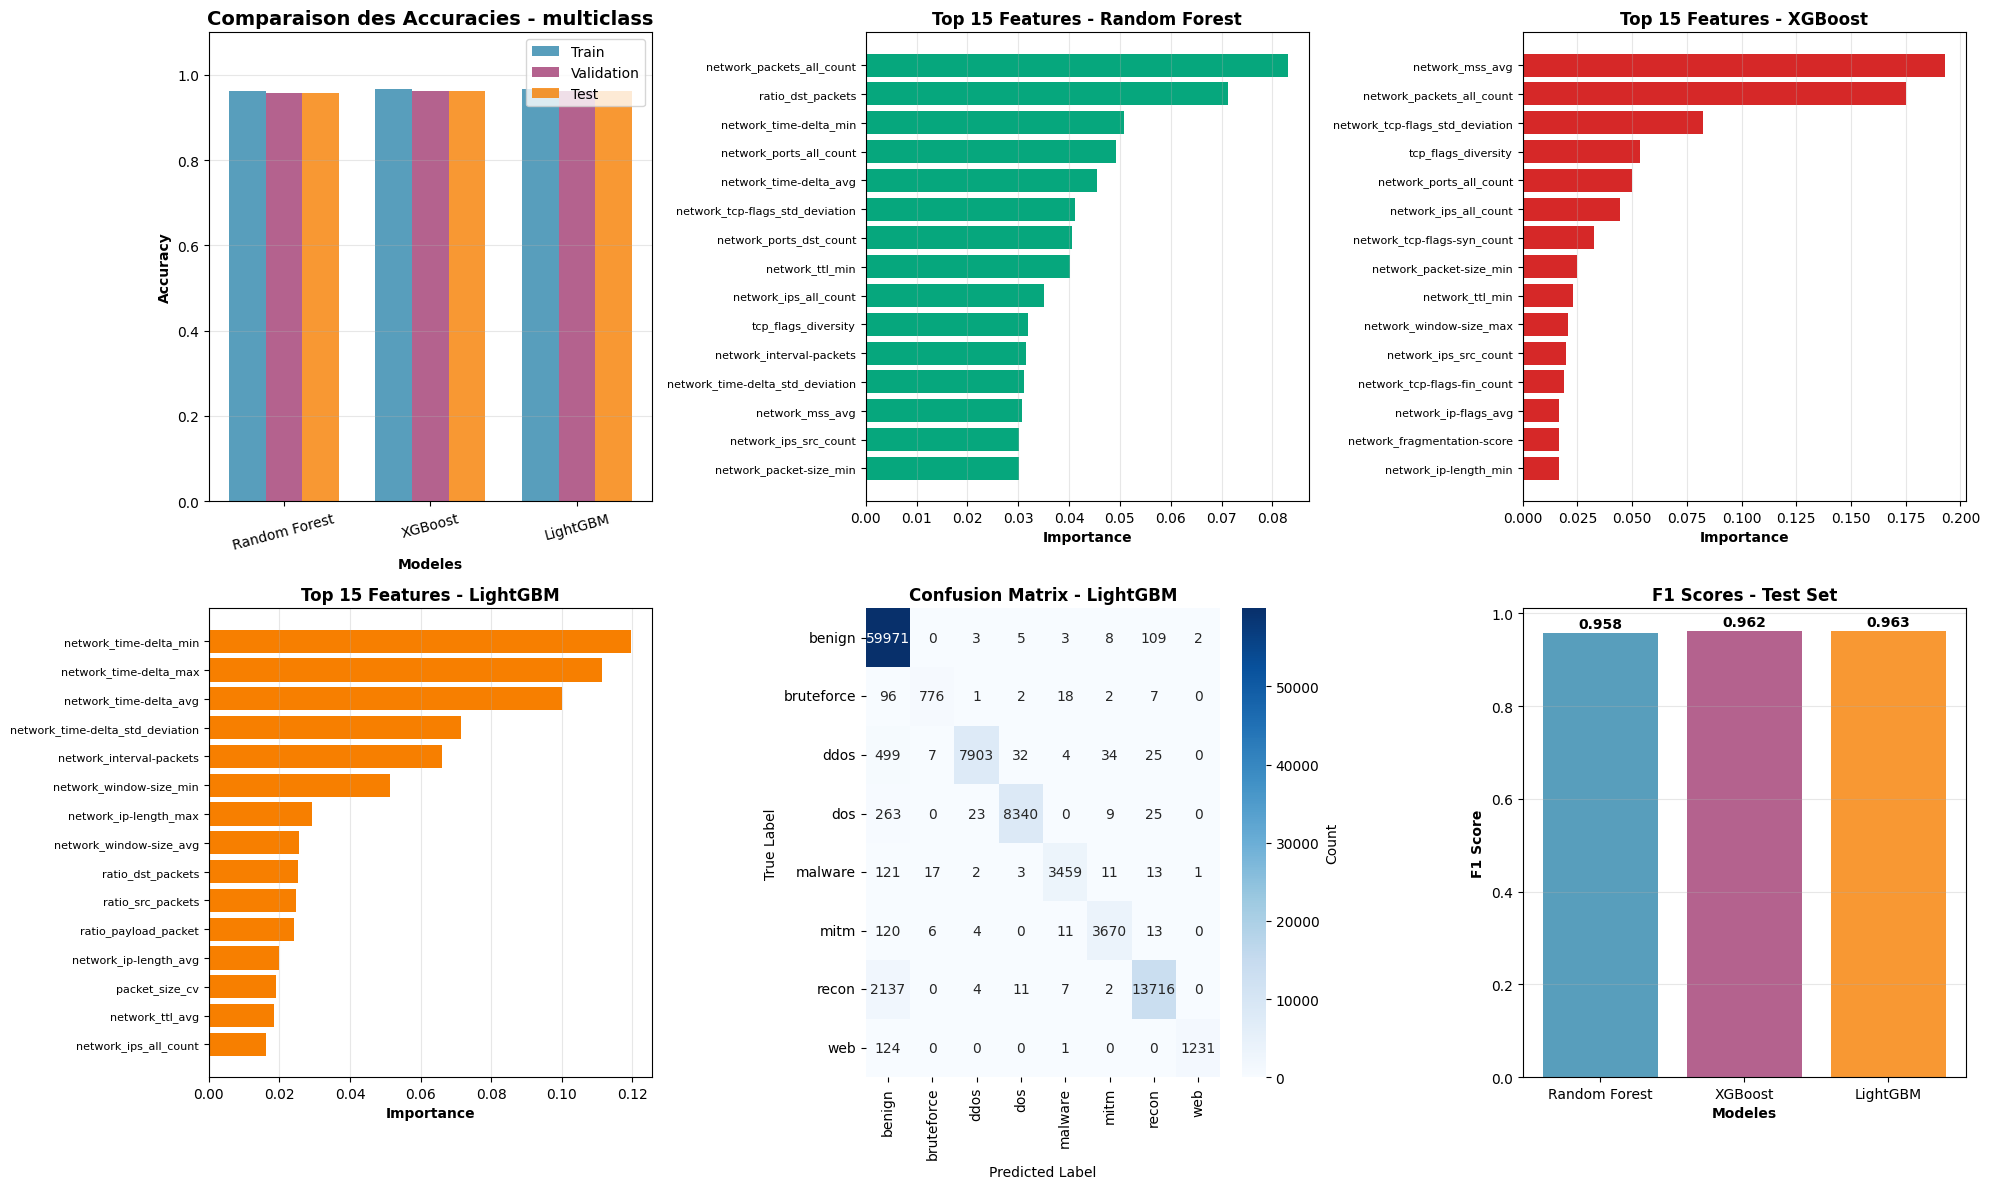


Visualisations completees!


In [13]:
# ============================================================================
# CELLULE 13: CLASSIFICATION MULTICLASSE
# ============================================================================
print("\n" + "=" * 80)
print("ETAPE 7: CLASSIFICATION MULTICLASSE (TYPES D'ATTAQUES)")
print("=" * 80)

# Encodage multiclasse
label_encoder_multi = LabelEncoder()
y_multi = label_encoder_multi.fit_transform(df_all['label2'])
print(f"\nClasses multiclasses ({len(label_encoder_multi.classes_)}): {label_encoder_multi.classes_}")

# Entrainement
results_multi, comparison_multi, importance_multi, X_train_multi, X_test_multi, y_train_multi, y_test_multi = \
    train_and_evaluate_models(X_final, y_multi, label_encoder_multi, 'multiclass')


## Interpretation of Results - Multiclass Classification (Attack Types)

### 1. Dataset and Split
- **Multiclass labels (8 classes)**: `benign`, `bruteforce`, `ddos`, `dos`, `malware`, `mitm`, `recon`, `web`.  
- **Data split**: 70% training, 15% validation, 15% test.  
- **Class distribution**: Highly imbalanced, e.g., `benign` 58.4%, `recon` 15.4%, `bruteforce` 0.88%, `web` 1.32%.  
- **Interpretation**: Rare attack types are underrepresented, which may affect recall for minority classes.

### 2. Model Performance Metrics
| Model         | Test Accuracy | Test F1  |
|---------------|---------------|----------|
| Random Forest | 0.9586        | 0.9579   |
| XGBoost       | 0.9624        | 0.9618   |
| LightGBM      | 0.9632        | 0.9626   |

**Interpretation**:  
- Accuracy and F1 are slightly lower than the binary case due to increased complexity and class imbalance.  
- LightGBM achieves the highest test accuracy and F1 among single models, indicating strong multiclass performance.  
- XGBoost is close behind, showing consistent performance.  
- Random Forest performs slightly worse but still maintains strong predictive ability.

### 3. Ensemble Models
| Ensemble Combination | Test Accuracy | Test F1  |
|--------------------|---------------|----------|
| RF + XGB            | 0.9614        | 0.9608   |
| RF + LGB            | 0.9620        | 0.9614   |
| XGB + LGB           | 0.9630        | 0.9625   |
| RF + XGB + LGB      | 0.9624        | 0.9618   |

**Interpretation**:  
- The **XGBoost + LightGBM ensemble** gives the best overall performance, slightly improving over individual models.  
- Ensembles help improve stability and F1-scores across minority classes.

### 4. Classification Report Insights
- **Benign class**: Recall ~1.0 → almost all benign traffic is correctly detected.  
- **Minority attack classes** (e.g., `bruteforce`, `web`): Recall ~0.86–0.91 → some attacks are missed, expected due to limited samples.  
- **Common attacks** (e.g., `ddos`, `dos`, `malware`): High precision and recall (~0.95–0.98).  
- **Interpretation**: The model performs very well for majority and mid-size classes, while rare attack types remain challenging, which is typical in imbalanced multiclass classification.

### 5. Feature Importance
- Top predictive features include:
  - **Network packet counts**: `network_packets_all_count`, `network_ips_all_count`  
  - **Timing features**: `network_time-delta_min`, `network_time-delta_avg`  
  - **TCP flag statistics & ratios**: `network_tcp-flags_std_deviation`, `tcp_flags_diversity`  
  - **Port usage & window sizes**: `network_ports_all_count`, `network_window-size_min`  
- **Interpretation**: Network traffic patterns, timing, and TCP flags are critical for distinguishing between different attack types, which informs future feature engineering and monitoring.

###  Conclusion
- **Best model**: **LightGBM** for single model; **XGBoost + LightGBM ensemble** for optimal multiclass performance.  
- **Performance**: High overall accuracy (~96.3%), strong weighted F1 (~0.96), robust even with imbalanced classes.  
- **Key insight**: Rare attacks remain harder to detect; focusing on additional features or resampling strategies could further improve minority class recall.


In [14]:
# ============================================================================
# CELLULE 14: RESUME FINAL
# ============================================================================
print("\n" + "=" * 80)
print("RESUME FINAL DES DEUX CLASSIFICATIONS")
print("=" * 80)

print("\nCLASSIFICATION BINAIRE:")
print(comparison_binary.to_string(index=False))

print("\n\nCLASSIFICATION MULTICLASSE:")
print(comparison_multi.to_string(index=False))

print("\n" + "=" * 80)
print("PIPELINE TERMINE AVEC SUCCES!")
print("=" * 80)


RESUME FINAL DES DEUX CLASSIFICATIONS

CLASSIFICATION BINAIRE:
                  Modele  Train Acc  Val Acc  Test Acc  Test F1  CV Mean  CV Std
           Random Forest     0.9642   0.9642    0.9623   0.9620   0.9631  0.0004
                 XGBoost     0.9656   0.9653    0.9633   0.9630   0.9643  0.0005
                LightGBM     0.9651   0.9650    0.9631   0.9628   0.9642  0.0004
      Ensemble: RF + XGB        NaN      NaN    0.9631   0.9628      NaN     NaN
      Ensemble: RF + LGB        NaN      NaN    0.9629   0.9627      NaN     NaN
     Ensemble: XGB + LGB        NaN      NaN    0.9633   0.9631      NaN     NaN
Ensemble: RF + XGB + LGB        NaN      NaN    0.9631   0.9629      NaN     NaN


CLASSIFICATION MULTICLASSE:
                  Modele  Train Acc  Val Acc  Test Acc  Test F1  CV Mean  CV Std
           Random Forest     0.9618   0.9580    0.9586   0.9579   0.9580  0.0009
                 XGBoost     0.9659   0.9617    0.9624   0.9618   0.9621  0.0009
               

# 🏆 Evaluation of the Best Models

---

## 🔹 Best Binary Model: XGBoost + LightGBM Ensemble

**Classification Report:**

| Class   | Precision | Recall | F1-score | Support |
|---------|-----------|--------|----------|---------|
| attack  | 1.00      | 0.91   | 0.95     | 42,750  |
| benign  | 0.94      | 1.00   | 0.97     | 60,101  |
| **Accuracy** | - | - | **0.96** | 102,851 |
| **Macro Avg** | 0.97 | 0.96 | 0.96 | 102,851 |
| **Weighted Avg** | 0.97 | 0.96 | 0.96 | 102,851 |

**Interpretation:**

- Overall accuracy is very high: **96%**.
- Attack detection precision is perfect (1.0), recall 91% → **9% of attacks are missed**.
- Benign traffic is detected with 100% recall → **minimal false positives**.
- **ROC-AUC** = 0.9844 → the model has excellent ability to **distinguish between attack and benign classes**.  
  - ROC curve plots **True Positive Rate (Recall)** vs **False Positive Rate** at different thresholds.  
  - AUC (Area Under the Curve) close to 1 → **excellent discrimination**.
- The XGBoost + LightGBM ensemble provides the **best balance and stability** across train, validation, and test sets.

**Top Features Driving Prediction:**

1. `network_packets_all_count`  
2. `network_mss_avg`  
3. `network_time-delta_min`  
4. `network_packet-size_min`  
5. `network_time-delta_avg`  
6. `ratio_dst_packets`  
7. `network_time-delta_max`  
8. `network_ports_all_count`  
9. `network_ports_dst_count`  
10. `network_interval-packets`  

---

## 🔹 Best Multiclass Model: LightGBM

**Classification Report:**

| Class      | Precision | Recall | F1-score | Support |
|------------|-----------|--------|----------|---------|
| benign     | 0.95      | 1.00   | 0.97     | 60,101 |
| bruteforce | 0.96      | 0.86   | 0.91     | 902    |
| ddos       | 1.00      | 0.93   | 0.96     | 8,504  |
| dos        | 0.99      | 0.96   | 0.98     | 8,660  |
| malware    | 0.99      | 0.95   | 0.97     | 3,627  |
| mitm       | 0.98      | 0.96   | 0.97     | 3,824  |
| recon      | 0.99      | 0.86   | 0.92     | 15,877 |
| web        | 1.00      | 0.91   | 0.95     | 1,356  |
| **Accuracy** | - | - | **0.96** | 102,851 |
| **Macro Avg** | 0.98 | 0.93 | 0.95 | 102,851 |
| **Weighted Avg** | 0.96 | 0.96 | 0.96 | 102,851 |

**Interpretation:**

- Overall accuracy: **96%**, excellent for an 8-class problem.
- Majority class **benign** is perfectly recognized (recall = 1.0).
- Rare classes like **bruteforce** have slightly lower recall (86%) → **some infrequent attacks may be missed**.
- High F1-scores for most classes indicate good **balance between precision and recall**.
- **Multi-class ROC-AUC (macro-averaged)** could be computed to evaluate how well the model separates each class → a higher value (~1.0) indicates robust distinction between all attack types.

**Top Features Driving Prediction:**

- Most important features are **network metrics** and TCP flags:
  - `network_packets_all_count`, `network_mss_avg`, `network_time-delta_min`, `network_time-delta_avg`, `network_tcp-flags_std_deviation`, etc.

---

## 🔹 Visualization: Confusion Matrices

- **Binary**: misclassifications mainly involve **missed attacks**.
- **Multiclass**: main confusions occur on **rare attack types** (bruteforce, recon, web).
- Heatmaps are recommended to clearly visualize class-wise errors and guide model improvements.

---

> ✅ **Conclusion:**
>
> - For **binary classification**, the **XGBoost + LightGBM ensemble** is highly effective, reliable, and achieves excellent discrimination between attack and benign traffic.  
> - For **multiclass classification**, **LightGBM** performs best across most attack types, with ensembles slightly improving stability.  
> - **ROC-AUC values confirm the strong predictive power** of both models.  
> - **Network features** play a crucial role in model performance, supporting deployment for cybersecurity monitoring.
